In [1]:
import pandas as pd
import numpy as np
from pylab import plt, mpl
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
plt.style.use( "seaborn" )
mpl.rcParams[ 'font.family' ] = 'serif'

策略设计说明：\
（1）每个执行日先平掉上一期已有仓位，再计算这一期调整的多空仓位\
(2）对冲策略：根据模型预测的涨跌概率p0,p1,同时建立多空仓位，仓位为p0,p1\
(3)不对冲概率调仓:根据模型预测涨跌类型，只建立一边的仓位（多或者空），仓位为p0或者p1\
(4)不对冲满仓:根据模型预测涨跌类型，只建立一边的仓位（多或者空），仓位为100%

In [2]:
from timing import strategy,timing_backtest

说明：本次研究采用的上证综指的2000-2022的收益率月度级别的时序数列

#  一、 数据初探与第一个模型

In [3]:
df=pd.read_csv("D:/数据/指数时间序列预测/000001SH.csv")
df["trade_date"]=df["trade_date"].astype("str")
df["daily_return"]=df["close"]/df["pre_close"]
df["trade_date"]=pd.to_datetime(df["trade_date"])
df.index=df["trade_date"]
data=df["daily_return"].resample("M").prod().to_frame()
data.columns=["monthly_return"]
data

,monthly_return
trade_date,
2000-01-31,1.123240
2000-02-29,1.116991
2000-03-31,1.049952
2000-04-30,1.020051
2000-05-31,1.031712
...,...
2022-07-31,0.957224
2022-08-31,0.984292
2022-09-30,0.944491


In [4]:
#ADF检验
from statsmodels.tsa.stattools import adfuller
adf_res=adfuller(data)
adf_res

(-5.1172504210215735,
 1.294146758205897e-05,
 14,
 260,
 {'1%': -3.4557539868570775,
  '5%': -2.8727214497041422,
  '10%': -2.572728476331361},
 -624.5122819535507)

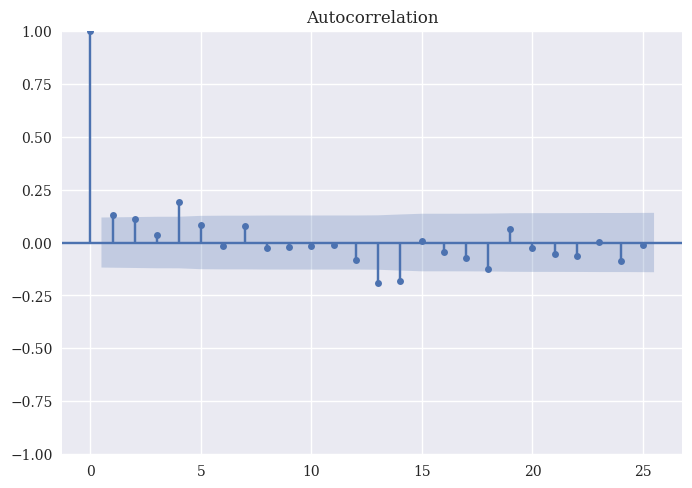

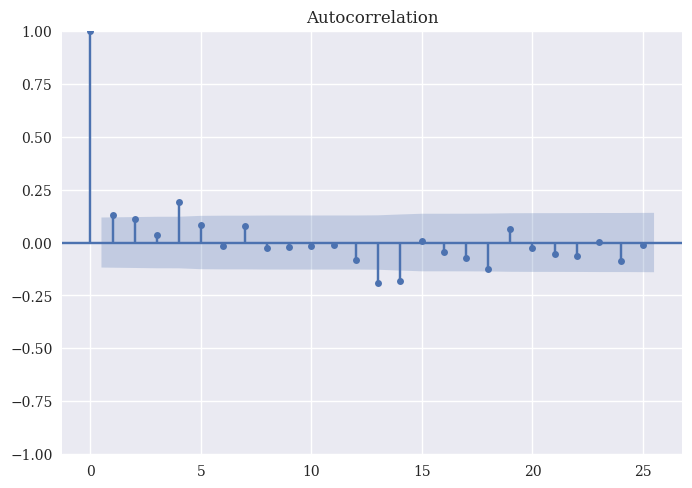

In [5]:
#ACF
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data)

根据ACF的显著性显示，我们构造最初的几个滞后特征

In [6]:
lag_list=[1,2,4,13,14,18]
for i in lag_list:
    data["lag-"+"{}".format(i)]=data.shift(i)["monthly_return"]
#然后使用线性回归对其相关性的显著性做检验
data_test=data.dropna(how="any")
data_test['intercept']=1
X=data_test.iloc[:,1:]
Y=data_test.iloc[:,0]
import statsmodels.api as sm
model =sm.OLS(Y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         monthly_return   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     5.474
Date:                Fri, 10 Mar 2023   Prob (F-statistic):           2.43e-05
Time:                        10:16:27   Log-Likelihood:                 322.56
No. Observations:                 257   AIC:                            -631.1
Df Residuals:                     250   BIC:                            -606.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
lag-1          0.0614      0.061      1.000      0.318      -0.060       0.182
lag-2          0.0675      0.061      1.114      0.266      -0.052       0.187
lag-4          0.1671      0.061      2.733      0.007       0.047       0.288
lag-13        -0.1697      0.061     -2.801      0.005      -0.289      -0.050
lag-14        -0.1491      0.063     -2.376      0.018      -0.273      -0.025
lag-18        -0.0430      0.062     -0.694      0.488      -0.165       0.079
intercept      1.0705      0.149      7.206      0.000       0.778       1.363
==============================================================================
Omnibus:                       10.118   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               20.712
Skew:                          -0.016   Prob(JB):                     3.18e-05
Kurtosis:                       4.390   Cond. No.                         97.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

基本确定了我们用来预测未来收益率的特征，开始进行用以执行策略的模型，我们只关心未来的涨跌情况，在上涨时做多，在下跌时做空，我们将问题进一步转化成分类问题，并使用逻辑回归来拟合

##  准备建立第一个模型

In [7]:
data_classification=data_test.copy()
#构造离散label
data_classification['monthly_return_type']=data_classification['monthly_return'].apply(lambda x:1 if x>1 else 0)
#选择检验显著的三个滞后特征作为预测因子
factor_names=['lag-4','lag-13',"lag-14"]
x,y=data_classification[factor_names],data_classification['monthly_return_type']
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
lr=LogisticRegression().fit(x,y)
#查看线性特征估计系数
print([[lr.feature_names_in_[i],lr.coef_[0][i]] for i in range(len(lr.feature_names_in_))])
#查看模型拟合效果
print("auc:",roc_auc_score(y,lr.predict_proba(x)[:,1]))
print("accuracy:",lr.score(x,y))

[['lag-4', 0.6459621157632847], ['lag-13', -1.1404907029724598], ['lag-14', -0.9986829092319967]]
auc: 0.6204423918327662
accuracy: 0.5680933852140078


## 第一次回测

In [8]:
data_backtest=data_classification.copy()
data_backtest['close']=data_backtest['monthly_return'].shift(1).cumprod()
data_backtest.iloc[0,-1]=1
data_backtest

,monthly_return,lag-1,lag-2,lag-4,lag-13,lag-14,lag-18,intercept,monthly_return_type,close
trade_date,,,,,,,,,,
2001-07-31,0.865778,1.001704,1.044863,1.078398,1.017710,1.031712,1.123240,1,0,1.000000
2001-08-31,0.955121,0.865778,1.001704,1.003033,1.049496,1.017710,1.116991,1,0,0.865778
2001-09-30,0.962232,0.955121,0.865778,1.044863,0.998844,1.049496,1.049952,1,0,0.826922
2001-10-31,0.957109,0.962232,0.955121,1.001704,0.945063,0.998844,1.020051,1,0,0.795692
2001-11-30,1.034824,0.957109,0.962232,0.865778,1.026765,0.945063,1.031712,1,1,0.761564
...,...,...,...,...,...,...,...,...,...,...
2022-07-31,0.957224,1.066592,1.045737,0.939317,0.993284,1.048920,1.002879,1,0,1.532265
2022-08-31,0.984292,0.957224,1.066592,0.936923,0.946024,0.993284,1.007468,1,0,1.466721
2022-09-30,0.944491,0.984292,0.957224,1.045737,1.043146,0.946024,0.980859,1,0,1.443682


### 对冲 

In [9]:
strategy_lr=strategy()
strategy_lr.set_strategy(model=lr,factor_name=factor_names,hedge=True)
backtest=timing_backtest()
backtest.fit_data(data_backtest)
backtest.set_account(1000)
backtest.run(strategy=strategy_lr)

当前价格: 1.0
平仓现金流入: 0.0
目前可用现金: 1000.0
当前价格: 0.8657776791917507
平仓现金流入: 53.66355619546914
目前可用现金: 991.6804888500892
当前价格: 0.8269224613384226
平仓现金流入: 25.177007461352275
目前可用现金: 990.4974781622159
当前价格: 0.7956915802273102
平仓现金流入: 50.570662883064244
目前可用现金: 988.5125804965148
当前价格: 0.7615635323072875
平仓现金流入: 89.73389008411243
目前可用现金: 984.4913237386414
当前价格: 0.7880839249622077
平仓现金流入: 32.074385635529836
目前可用现金: 985.5706825153864
当前价格: 0.7420872315014821
平仓现金流入: 2.810954394450505
目前可用现金: 985.3964515057085
当前价格: 0.6725182583275516
平仓现金流入: 19.51320187888348
目前可用现金: 983.3778989961819
当前价格: 0.68741256313601
平仓现金流入: 50.513361698732695
目前可用现金: 984.4723820568472
当前价格: 0.7231217445759276
平仓现金流入: 108.54548470248159
目前可用现金: 989.8325726980481
当前价格: 0.7519058587601875
平仓现金流入: 25.567443406604582
目前可用现金: 990.811333804696
当前价格: 0.6833693337643466
平仓现金流入: -7.636169178709565
目前可用现金: 991.5771810178072
当前价格: 0.78121386149595
平仓现金流入: 48.40829574955444
目前可用现金: 997.64016462493
当前价格: 0.7446223651719612
平仓现金流入: 53.271

当前价格: 1.1686713744500181
平仓现金流入: -74.6757536301908
目前可用现金: 1379.3223060934101
当前价格: 1.0813068720021246
平仓现金流入: 14.968115508951769
目前可用现金: 1378.1129528580968
当前价格: 1.189120160286453
平仓现金流入: -50.427898184197716
目前可用现金: 1373.5408349964368
当前价格: 1.1897040119854168
平仓现金流入: -152.24027454150178
目前可用现金: 1373.4661225116117
当前价格: 1.1973053553402606
平仓现金流入: 109.45725084939534
目前可用现金: 1374.1610347515616
当前价格: 1.3430099426112112
平仓现金流入: 189.5305224869146
目前可用现金: 1394.7234041562963
当前价格: 1.2714806704511088
平仓现金流入: 39.03687497230624
目前可用现金: 1392.5273194504362
当前价格: 1.2660235731814162
平仓现金流入: -19.427562732618867
目前可用现金: 1392.6110604658415
当前价格: 1.2581864348933236
平仓现金流入: 23.37292913228248
目前可用现金: 1392.4654724411039
当前价格: 1.3097452738444826
平仓现金流入: 200.59273871871733
目前可用现金: 1400.3619152967538
当前价格: 1.3200755554759422
平仓现金流入: 108.9994165850378
目前可用现金: 1401.2148927390806
当前价格: 1.312591804272214
平仓现金流入: 55.900616585109105
目前可用现金: 1400.8961749889804
当前价格: 1.2368350531563506
平仓现金流入: 125.1147889282795
目前可用现

-------年化收益-------
2001 -1.44%
2002 -0.70%
2003 -0.13%
2004 -0.10%
2005 -0.43%
2006 6.73%
2007 8.88%
2008 9.78%
2009 10.47%
2010 1.64%
2011 0.04%
2012 -0.94%
2013 2.50%
2014 1.38%
2015 2.28%
2016 4.43%
2017 0.79%
2018 -1.04%
2019 -0.10%
2020 1.65%
2021 0.04%
2022 -1.20%
平均年化收益率1.96%
-----夏普比率-----
夏普比率为0.5626546211672333


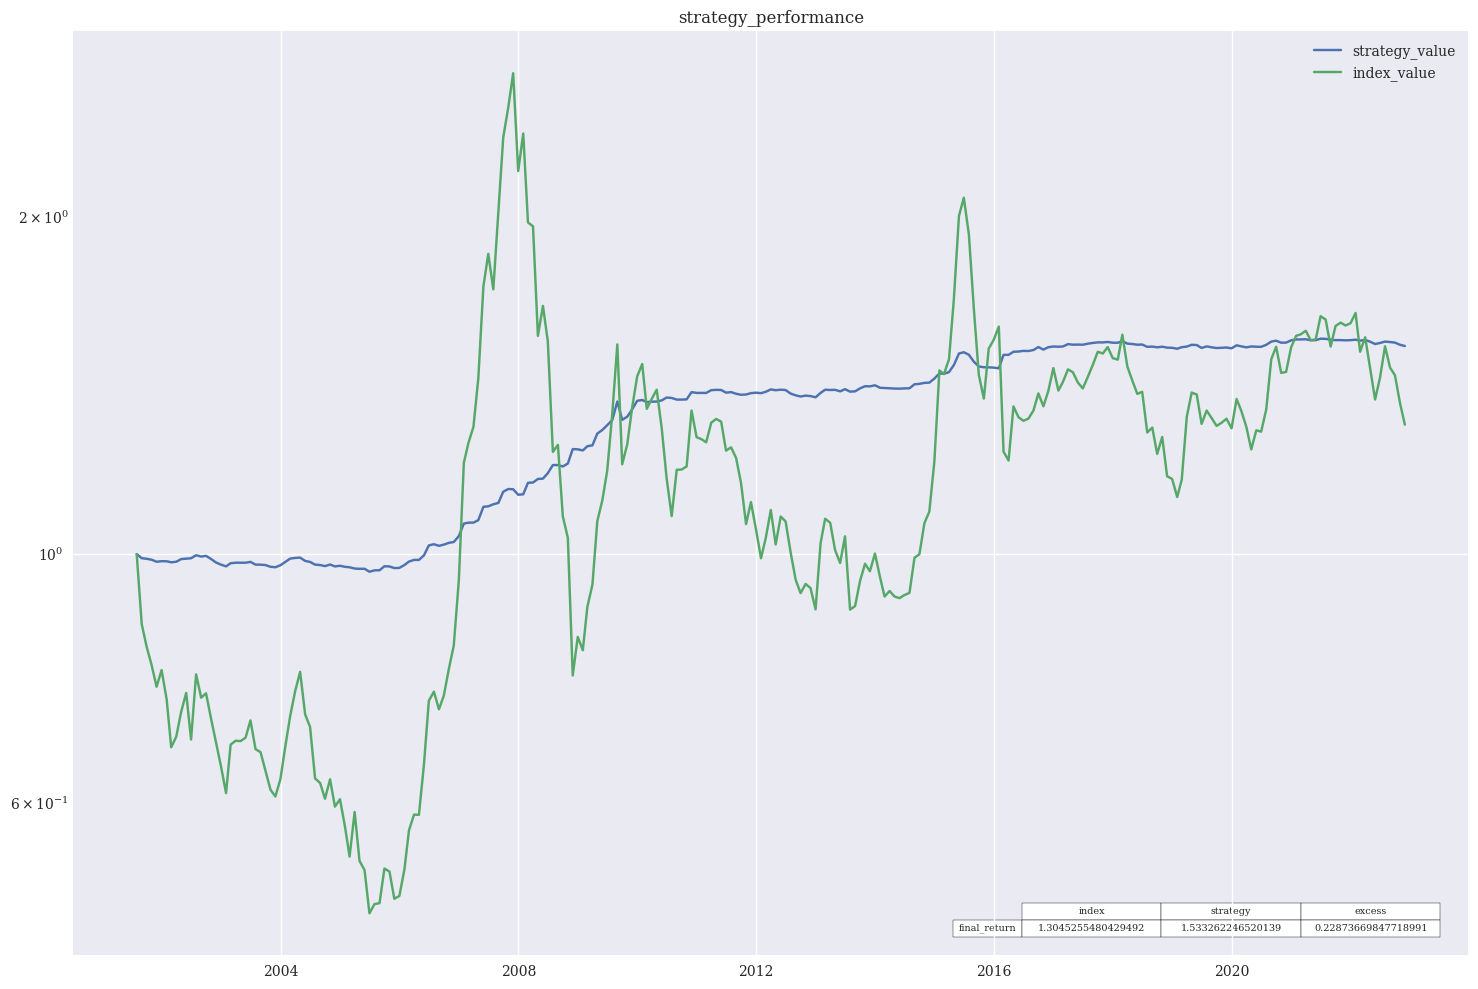

In [10]:
backtest.analysis()

###  不对冲按概率调仓

In [11]:
strategy_lr=strategy()
strategy_lr.set_strategy(model=lr,factor_name=factor_names,hedge=False)
backtest=timing_backtest()
backtest.fit_data(data_backtest)
backtest.set_account(1000)
backtest.run(strategy=strategy_lr)

当前价格: 1.0
平仓现金流入: 0.0
目前可用现金: 1000.0
当前价格: 0.8657776791917507
平仓现金流入: 459.72061769360994
目前可用现金: 928.7290840209199
当前价格: 0.8269224613384226
平仓现金流入: 455.31372722487555
目前可用现金: 907.3349208556107
当前价格: 0.7956915802273102
平仓现金流入: 459.6958919395355
目前可用现金: 889.2918648459831
当前价格: 0.7615635323072875
平仓现金流入: 465.9380826564474
目前可用现金: 868.4117195421682
当前价格: 0.7880839249622077
平仓现金流入: 463.4727521941005
目前可用现金: 884.0083825163983
当前价格: 0.7420872315014821
平仓现金流入: 417.467162238102
目前可用现金: 858.1325713229719
当前价格: 0.6725182583275516
平仓现金流入: 397.3388437008244
目前可用现金: 817.0296644262495
当前价格: 0.68741256313601
平仓现金流入: 438.54649625397025
目前可用现金: 826.5317386363708
当前价格: 0.7231217445759276
平仓现金流入: 480.2995586546663
目前可用现金: 850.2498804488123
当前价格: 0.7519058587601875
平仓现金流入: 453.0281937270092
目前可用现金: 867.5924973535786
当前价格: 0.6833693337643466
平仓现金流入: -397.5988057464164
目前可用现金: 907.4685045753961
当前价格: 0.78121386149595
平仓现金流入: 540.850804054624
目前可用现金: 975.20833115073
当前价格: 0.7446223651719612
平仓现金流入: 490.801951

当前价格: 0.9135397061255973
平仓现金流入: 2109.284254120509
目前可用现金: 3903.103122146694
当前价格: 0.9193346541962435
平仓现金流入: 2144.523279817263
目前可用现金: 3916.6209428729217
当前价格: 0.9234902085729387
平仓现金流入: 2060.2363341375
目前可用现金: 3925.8916682535205
当前价格: 0.9925763564930092
平仓现金流入: 2342.1850118708203
目前可用现金: 4088.914431316303
当前价格: 0.9996267639141205
平仓现金流入: 2319.325075549283
目前可用现金: 4105.272723545888
当前价格: 1.0657530752361861
平仓现金流入: 2256.5258547540902
目前可用现金: 4245.282388678395
当前价格: 1.0911395914830184
平仓现金流入: 2210.6060838373473
目前可用现金: 4296.71447647058
当前价格: 1.209558753908326
平仓现金流入: 2565.361848897168
目前可用现金: 4547.870528611612
当前价格: 1.4583572532101017
平仓现金流入: 2882.8850852159962
目前可用现金: 5039.696164121979
当前价格: 1.4473952627997608
平仓现金流入: 2731.5593379967095
目前可用现金: 5019.008430758477
当前价格: 1.4924533084364096
平仓现金流入: 2886.9990509152976
目前可用现金: 5106.168634869241
当前价格: 1.6897438881683977
平仓现金流入: 3209.490212184559
目前可用现金: 5480.901272779472
当前价格: 2.0025244515934406
平仓现金流入: 3666.877786826483
目前可用现金: 6053.64239424

-------年化收益-------
2001 -11.60%
2002 -0.50%
2003 -1.12%
2004 -1.68%
2005 -15.95%
2006 43.68%
2007 62.19%
2008 57.89%
2009 39.02%
2010 2.60%
2011 4.90%
2012 -8.04%
2013 13.93%
2014 9.71%
2015 2.49%
2016 27.72%
2017 3.66%
2018 -11.87%
2019 5.62%
2020 10.47%
2021 -1.71%
2022 -10.14%
平均年化收益率8.15%
-----夏普比率-----
夏普比率为0.46307479949360836


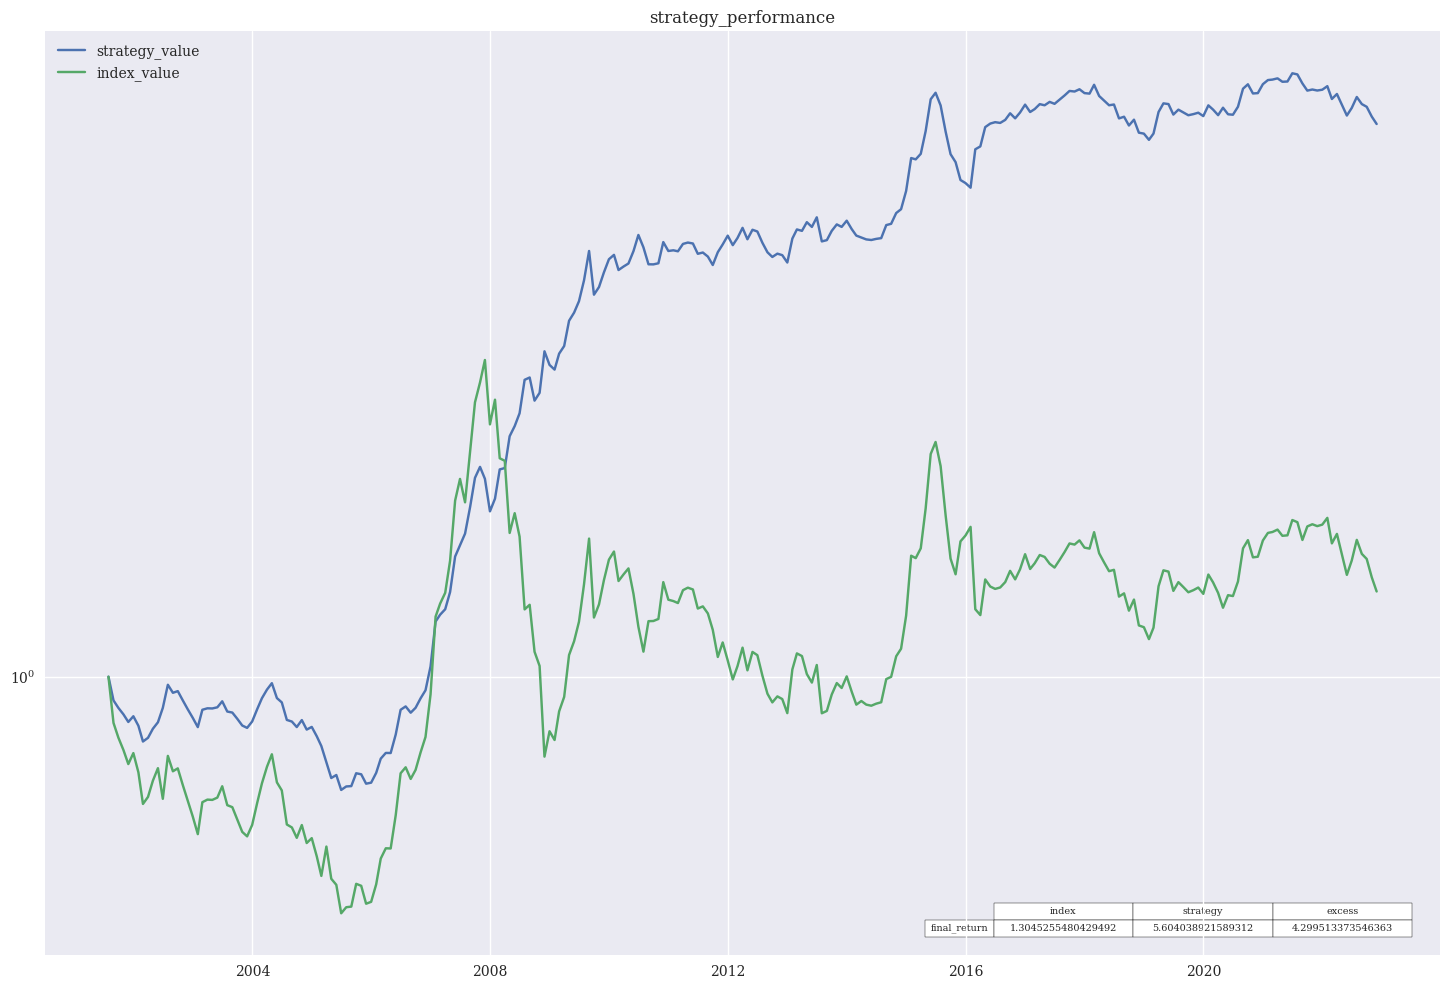

In [12]:
backtest.analysis()

### 不对冲满仓 

In [13]:
strategy_lr=strategy()
strategy_lr.set_strategy(model=lr,factor_name=factor_names,position=1,hedge=False)
backtest=timing_backtest()
backtest.fit_data(data_backtest)
backtest.set_account(1000)
backtest.run(strategy=strategy_lr)

当前价格: 1.0
平仓现金流入: 0.0
目前可用现金: 1000.0
当前价格: 0.8657776791917507
平仓现金流入: 865.7776791917507
目前可用现金: 865.7776791917507
当前价格: 0.8269224613384226
平仓现金流入: 826.9224613384226
目前可用现金: 826.9224613384226
当前价格: 0.7956915802273102
平仓现金流入: 795.6915802273103
目前可用现金: 795.6915802273103
当前价格: 0.7615635323072875
平仓现金流入: 761.5635323072876
目前可用现金: 761.5635323072876
当前价格: 0.7880839249622077
平仓现金流入: 788.0839249622078
目前可用现金: 788.0839249622078
当前价格: 0.7420872315014821
平仓现金流入: 742.0872315014823
目前可用现金: 742.0872315014823
当前价格: 0.6725182583275516
平仓现金流入: 672.5182583275517
目前可用现金: 672.5182583275517
当前价格: 0.68741256313601
平仓现金流入: 687.41256313601
目前可用现金: 687.41256313601
当前价格: 0.7231217445759276
平仓现金流入: 723.1217445759277
目前可用现金: 723.1217445759277
当前价格: 0.7519058587601875
平仓现金流入: 751.9058587601876
目前可用现金: 751.9058587601876
当前价格: 0.6833693337643466
平仓现金流入: -683.3693337643467
目前可用现金: 820.4423837560284
当前价格: 0.78121386149595
平仓现金流入: 937.9129719186542
目前可用现金: 937.9129719186542
当前价格: 0.7446223651719612
平仓现金流入: 893.981801779

当前价格: 1.9283896294604055
平仓现金流入: 18779.52784905703
目前可用现金: 18779.52784905703
当前价格: 1.6517942293872112
平仓现金流入: 16085.91710813582
目前可用现金: 16085.91710813582
当前价格: 1.4454216626919525
平仓现金流入: 14076.167986730597
目前可用现金: 14076.167986730597
当前价格: 1.3763494460667607
平仓现金流入: 13403.511592041392
目前可用现金: 13403.511592041392
当前价格: 1.5250309877762358
平仓现金流入: -14851.439495467795
目前可用现金: 11955.583688614988
当前价格: 1.5533639114815272
平仓现金流入: -12177.70156242665
目前可用现金: 11733.465814803327
当前价格: 1.595643402544379
平仓现金流入: -12052.827529972898
目前可用现金: 11414.104099633756
当前价格: 1.2342495566785974
平仓现金流入: -8828.948186287822
目前可用现金: 13999.26001297969
当前价格: 1.211877881761901
平仓现金流入: -13745.513197848166
目前可用现金: 14253.006828111214
当前价格: 1.3543179270346983
平仓现金流入: 15928.257254266386
目前可用现金: 15928.257254266386
当前价格: 1.324746162470077
平仓现金流入: -15580.461021162384
目前可用现金: 16276.053487370387
当前价格: 1.314959230212979
平仓现金流入: -16155.809596573386
目前可用现金: 16396.297378167386
当前价格: 1.3208157846584274
平仓现金流入: -16469.32307059395
目前可用

-------年化收益-------
2001 -21.19%
2002 -1.50%
2003 -2.58%
2004 -4.04%
2005 -29.77%
2006 90.97%
2007 131.06%
2008 118.48%
2009 70.77%
2010 2.27%
2011 9.52%
2012 -15.14%
2013 25.07%
2014 18.10%
2015 -0.39%
2016 54.33%
2017 6.46%
2018 -21.98%
2019 10.96%
2020 19.34%
2021 -3.62%
2022 -18.81%
平均年化收益率13.30%
-----夏普比率-----
夏普比率为0.4519990136447856


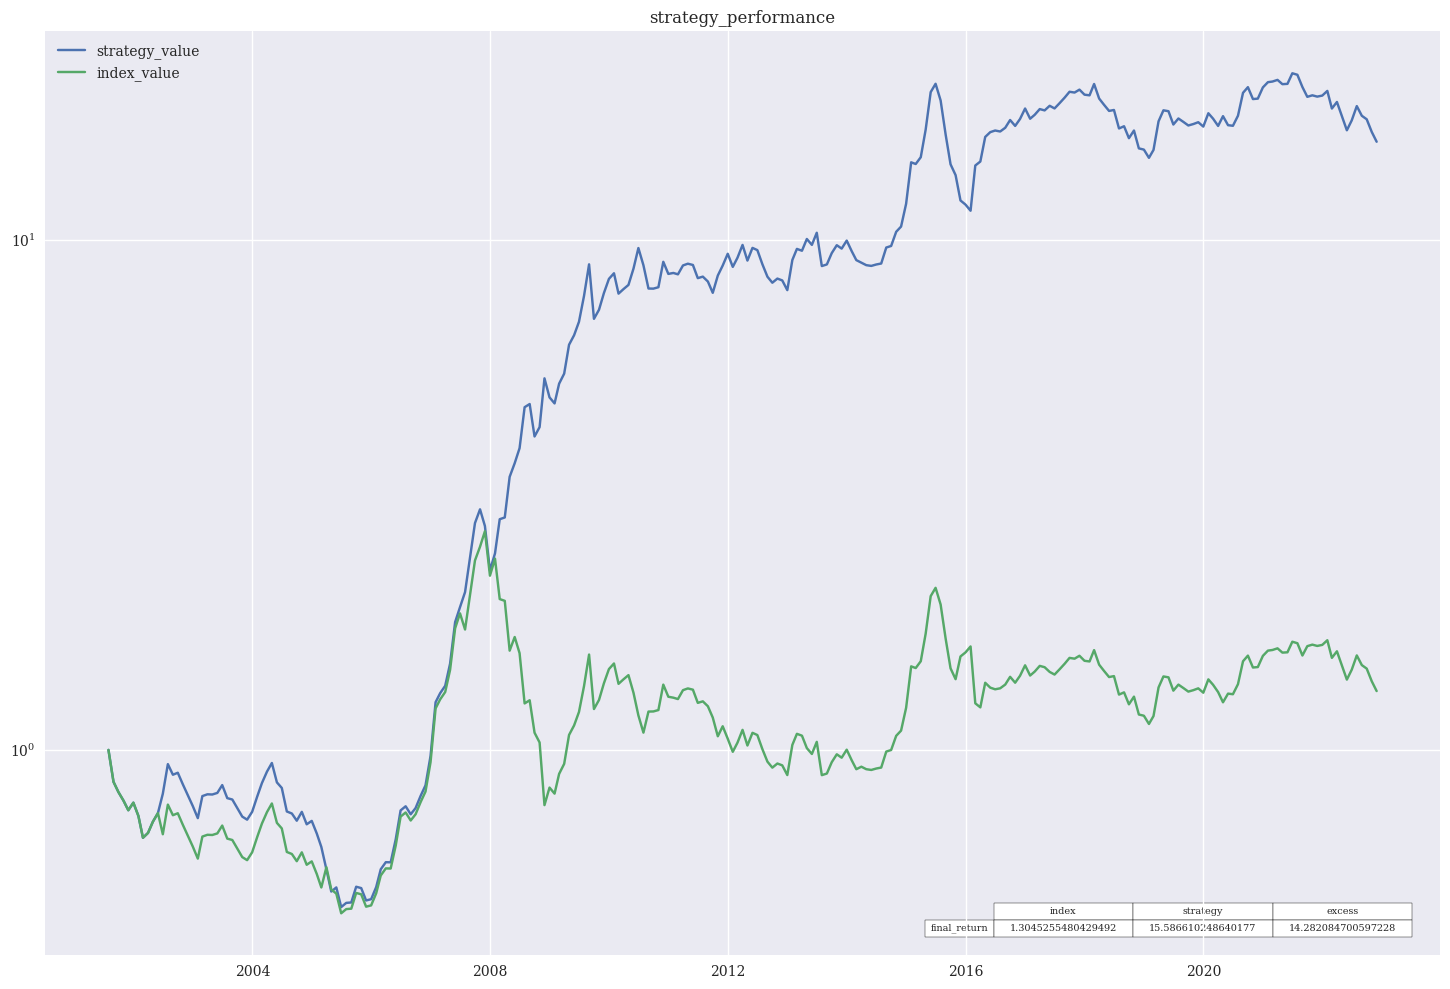

In [14]:
backtest.analysis()

# 二、特征衍生1：引入传统趋势与波动，第二个模型

In [15]:
for i in range(2,13):
    data_classification["rollings_std"+"{}".format(i)]=data_classification["monthly_return"].rolling(i,closed="left").std()
    data_classification["rollings_prod"+"{}".format(i)]=data_classification["monthly_return"].rolling(i,closed="left").apply(np.prod)
data=data_classification.dropna(how="any")
data['intercept']=1
#回归检验
data_test=data.drop(columns=['monthly_return_type'])
data_test['intercept']=1
X=data_test.iloc[:,1:]
Y=data_test.iloc[:,0]
import statsmodels.api as sm
model =sm.OLS(Y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         monthly_return   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     1.897
Date:                Fri, 10 Mar 2023   Prob (F-statistic):            0.00602
Time:                        10:16:30   Log-Likelihood:                 320.06
No. Observations:                 245   AIC:                            -582.1
Df Residuals:                     216   BIC:                            -480.6
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
lag-1              -0.4354      0.999     -0.436      0.664      -2.405       1.534
lag-2              -0.3867      0.997     -0.388      0.699      -2.353       1.579
lag-4              -0.5676      0.514     -1.104      0.271      -1.581       0.446
lag-13             -0.1395      0.067     -2.079      0.039      -0.272      -0.007
lag-14             -0.1674      0.069     -2.426      0.016      -0.303      -0.031
lag-18             -0.0033      0.067     -0.050      0.960      -0.135       0.128
intercept           2.2203      1.107      2.005      0.046       0.038       4.403
rollings_std2       0.1376      0.177      0.776      0.439      -0.212       0.487
rollings_prod2      0.5610      0.982      0.571      0.568      -1.375       2.497
rollings_std3      -0.5037      0.302     -1.666      0.097      -1.099       0.092
rollings_prod3     -0.8101      0.520     -1.558      0.121      -1.835       0.215
rollings_std4       0.3833      0.418      0.917      0.360      -0.441       1.207
rollings_prod4      0.6763      0.512      1.321      0.188      -0.332       1.685
rollings_std5       0.6878      0.525      1.309      0.192      -0.348       1.723
rollings_prod5      0.1514      0.100      1.514      0.132      -0.046       0.348
rollings_std6      -0.9890      0.645     -1.534      0.126      -2.260       0.282
rollings_prod6     -0.1777      0.101     -1.765      0.079      -0.376       0.021
rollings_std7      -0.2731      0.762     -0.358      0.720      -1.776       1.230
rollings_prod7      0.1043      0.101      1.030      0.304      -0.095       0.304
rollings_std8       1.2685      0.860      1.475      0.142      -0.427       2.964
rollings_prod8      0.0209      0.102      0.205      0.838      -0.180       0.222
rollings_std9       0.4525      0.952      0.475      0.635      -1.423       2.328
rollings_prod9     -0.1744      0.100     -1.746      0.082      -0.371       0.023
rollings_std10     -1.4968      1.095     -1.367      0.173      -3.656       0.662
rollings_prod10     0.1852      0.100      1.856      0.065      -0.012       0.382
rollings_std11     -0.5333      1.245     -0.428      0.669      -2.987       1.920
rollings_prod11     0.0100      0.097      0.103      0.918      -0.182       0.202
rollings_std12      0.8141      0.922      0.883      0.378      -1.004       2.632
rollings_prod12    -0.0598      0.062     -0.970      0.333      -0.181       0.062
==============================================================================
Omnibus:                        5.407   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.067   Jarque-Bera (JB):                7.826
Skew:                           0.012   Prob(JB):                       0.0200
Kurtosis:                       3.875   Cond. No.                     2.00e+03


In [16]:
#加入显著的新特征
factor_names.extend(['rollings_std3',"rollings_prod6","rollings_prod10"])
#第二次建立逻辑回归模型
x=data[factor_names]
y=data['monthly_return_type']
lr_1=LogisticRegression().fit(x,y)
#查看线性特征估计系数
print([[lr_1.feature_names_in_[i],lr_1.coef_[0][i]] for i in range(len(lr_1.feature_names_in_))])
#查看模型拟合效果
print("auc:",roc_auc_score(y,lr_1.predict_proba(x)[:,1]))
print("accuracy:",lr_1.score(x,y))

[['lag-4', 0.37576593240920075], ['lag-13', -1.2272850134184239], ['lag-14', -0.8819596852933771], ['rollings_std3', -0.06561914875652447], ['rollings_prod6', -0.028941008855290655], ['rollings_prod10', 0.6517853146899147]]
auc: 0.6239453595821615
accuracy: 0.5591836734693878


## 第二次回测 

### 对冲

In [17]:
data_backtest=data.copy()
data_backtest['close']=data_backtest['monthly_return'].shift(1).cumprod()
data_backtest.iloc[0,-1]=1
strategy_lr1=strategy()
strategy_lr1.set_strategy(model=lr_1,factor_name=factor_names,hedge=True)
backtest=timing_backtest()
backtest.fit_data(data_backtest)
backtest.set_account(1000)
backtest.run(strategy=strategy_lr1)

当前价格: 1.0
平仓现金流入: 0.0
目前可用现金: 1000.0
当前价格: 0.9531607180472713
平仓现金流入: 17.054818732785975
目前可用现金: 999.1619089539128
当前价格: 0.9618313033290913
平仓现金流入: 114.5780898157916
目前可用现金: 1000.1947918469286
当前价格: 0.9127764744583049
平仓现金流入: 106.14307553835675
目前可用现金: 994.4904046808997
当前价格: 0.8699995094517115
平仓现金流入: 84.64982867013555
目前可用现金: 990.32826123197
当前价格: 0.8276888538772067
平仓现金流入: 55.18518659703085
目前可用现金: 987.5072477412314
当前价格: 0.7835233486557531
平仓现金流入: 36.438771793586966
目前可用现金: 985.4532735122898
当前价格: 0.8655666842686935
平仓现金流入: 32.41846888944724
目前可用现金: 988.5260804623421
当前价格: 0.8725595944031326
平仓现金流入: 102.55901859127397
目前可用现金: 989.3480140071513
当前价格: 0.8717781798350025
平仓现金流入: 38.024648557620026
目前可用现金: 989.3139307793094
当前价格: 0.8780491183115902
平仓现金流入: -2.445916356686496
目前可用现金: 989.2964622907346
当前价格: 0.9096848660081774
平仓现金流入: -16.506168221416374
目前可用现金: 988.7224338630863
当前价格: 0.8576076825633165
平仓现金流入: 69.36757519212051
目前可用现金: 984.5101722289463
当前价格: 0.8522508952506265
平仓现金流入:

当前价格: 1.3651530344443583
平仓现金流入: 113.3051593764792
目前可用现金: 1844.6935689393192
当前价格: 1.2907249662355176
平仓现金流入: -35.74938791906504
目前可用现金: 1846.7550134391686
当前价格: 1.2568447638933589
平仓现金流入: 131.64418888477178
目前可用现金: 1843.2063398999094
当前价格: 1.3276435317814688
平仓现金流入: 90.69451925778003
目前可用现金: 1848.0427738250905
当前价格: 1.1421741088557846
平仓现金流入: 89.66511437930785
目前可用现金: 1833.4827020360744
当前价格: 1.150595539859194
平仓现金流入: 131.84132114176475
目前可用现金: 1834.4476741317676
当前价格: 1.210949032535785
平仓现金流入: 177.37999751263612
目前可用现金: 1843.2882628710263
当前价格: 1.2549709623125975
平仓现金流入: 201.10364575703875
目前可用现金: 1850.3425859089582
当前价格: 1.2358976589415527
平仓现金流入: 104.11281100827966
目前可用现金: 1848.7358386068604
当前价格: 1.2814240546010403
平仓现金流入: 58.462852969658
目前可用现金: 1850.812905106527
当前价格: 1.2211034558850606
平仓现金流入: 120.48891812587578
目前可用现金: 1844.8609412127507
当前价格: 1.1732658266773888
平仓现金流入: -86.7856596585408
目前可用现金: 1848.3994574747012
当前价格: 1.1866652103865745
平仓现金流入: -146.5254638107299
目前可用现金: 18

-------年化收益-------
2002 -1.25%
2003 -0.19%
2004 -0.43%
2005 0.28%
2006 12.34%
2007 41.69%
2008 12.12%
2009 4.83%
2010 0.26%
2011 -0.14%
2012 -0.58%
2013 0.98%
2014 2.01%
2015 3.84%
2016 2.37%
2017 0.62%
2018 -0.57%
2019 -1.29%
2020 1.70%
2021 0.22%
2022 -0.71%
平均年化收益率3.37%
-----夏普比率-----
夏普比率为0.4012187060296532


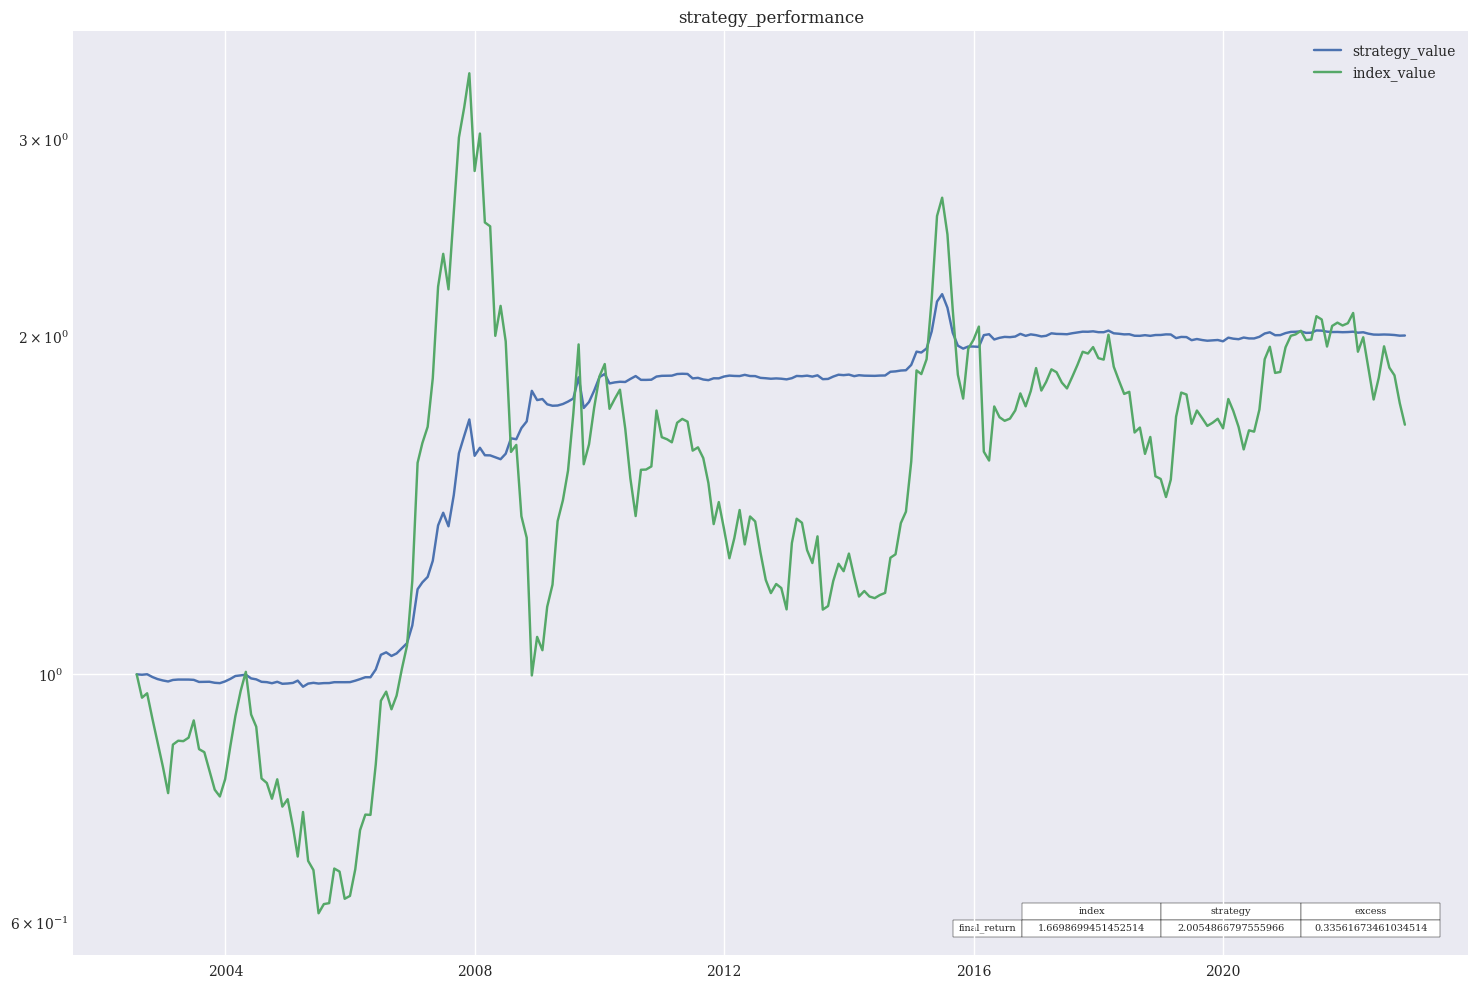

In [18]:
backtest.analysis()

# 三、特征衍生2：引入高阶矩 ，第三个模型

In [19]:
data=df["daily_return"].resample("M").prod().to_frame()
data.columns=["monthly_return"]
#lag_feature
lag_list=[1,2,4,13,14,18]
for i in lag_list:
    data["lag-"+"{}".format(i)]=data.shift(i)["monthly_return"]
#传统趋势和波动
for i in range(2,13):
    data["rollings_std"+"{}".format(i)]=\
    data["monthly_return"].rolling(i,closed="left").var()
    data["rollings_prod"+"{}".format(i)]=\
    data["monthly_return"].rolling(i,closed="left").apply(np.prod)
#加入高阶矩
def high_moment(x,j):
    if all(x.isnull()):
        return np.nan
    else:
        x=x.values
        return np.power((x-x.mean()),j).mean()     
for i in range(2,13):
    for j in range(3,13):
        data["rollings"+str(i)+"moment"+str(j)]=\
        data["monthly_return"].rolling(i,closed="left").apply(lambda x:high_moment(x,j))
data_test=data.dropna(how="any")
data_classification=data_test.copy()
data_classification['monthly_return_type']=data_classification['monthly_return'].apply(lambda x:1 if x>1 else 0)
data_classification

,monthly_return,lag-1,lag-2,lag-4,lag-13,lag-14,lag-18,rollings_std2,rollings_prod2,rollings_std3,...,rollings12moment4,rollings12moment5,rollings12moment6,rollings12moment7,rollings12moment8,rollings12moment9,rollings12moment10,rollings12moment11,rollings12moment12,monthly_return_type
trade_date,,,,,,,,,,,,,,,,,,,,,
2001-07-31,0.865778,1.001704,1.044863,1.078398,1.017710,1.031712,1.123240,0.000931,1.046643,0.000602,...,0.000005,-8.103376e-08,2.125695e-08,-4.114120e-10,9.020504e-11,-1.897002e-12,3.895671e-13,-8.514157e-15,1.695179e-15,0
2001-08-31,0.955121,0.865778,1.001704,1.003033,1.049496,1.017710,1.116991,0.009238,0.867253,0.008735,...,0.000031,-2.946397e-06,4.602143e-07,-5.434754e-08,7.589150e-09,-9.606000e-10,1.290725e-10,-1.673047e-11,2.216912e-12,0
2001-09-30,0.962232,0.955121,0.865778,1.044863,0.998844,1.049496,1.049952,0.003991,0.826922,0.004771,...,0.000029,-2.404898e-06,4.021245e-07,-4.338984e-08,6.168867e-09,-7.359189e-10,9.830803e-11,-1.220123e-11,1.588917e-12,0
2001-10-31,0.957109,0.962232,0.955121,1.001704,0.945063,0.998844,1.020051,0.000025,0.919048,0.002889,...,0.000030,-2.595182e-06,4.224944e-07,-4.746271e-08,6.685862e-09,-8.184955e-10,1.094132e-10,-1.383394e-11,1.812151e-12,0
2001-11-30,1.034824,0.957109,0.962232,0.865778,1.026765,0.945063,1.031712,0.000013,0.920961,0.000013,...,0.000028,-1.775880e-06,3.465659e-07,-3.194458e-08,4.854066e-09,-5.202046e-10,7.102184e-11,-8.165353e-12,1.060151e-12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-31,0.957224,1.066592,1.045737,0.939317,0.993284,1.048920,1.002879,0.000217,1.115375,0.004848,...,0.000008,-1.261695e-07,3.267822e-08,-5.851142e-10,1.467804e-10,-2.787676e-12,6.939716e-13,-1.395145e-14,3.391423e-15,0
2022-08-31,0.984292,0.957224,1.066592,0.936923,0.946024,0.993284,1.007468,0.005981,1.020967,0.003372,...,0.000008,-1.419763e-07,3.229947e-08,-7.360660e-10,1.484461e-10,-3.854552e-12,7.159462e-13,-2.071254e-14,3.561113e-15,0
2022-09-30,0.944491,0.984292,0.957224,1.045737,1.043146,0.946024,0.980859,0.000366,0.942189,0.003244,...,0.000007,1.368874e-08,2.943155e-08,2.614260e-10,1.371074e-10,2.191795e-12,6.718420e-13,1.513963e-14,3.396473e-15,0


In [20]:
#特征相关性筛选尝试
df_cr=data_classification.corr()["monthly_return"].sort_values()
print(df_cr)
ts_p=[i for i in df_cr.head(3).index]
ts_n=[i for i in df_cr.tail(3).index]
ts_select=ts_p+ts_n
ts_select.remove('monthly_return')
ts_select.remove('monthly_return_type')
factor_names=ts_select
print("筛选四因子：",factor_names)
x=data_classification[factor_names]
from sklearn.preprocessing import StandardScaler
x_value=StandardScaler().fit_transform(x.values)
x=pd.DataFrame(x_value,columns=x.columns,index=x.index)
y=data_classification['monthly_return_type']
lr_2=LogisticRegression().fit(x,y)
print("auc:",roc_auc_score(y,lr_2.predict_proba(x)[:,1]))
print("accuracy:",lr_2.score(x,y))
[[lr_2.feature_names_in_[i],lr_2.coef_[0][i]] for i in range(len(lr_2.feature_names_in_))]

lag-13                -0.202090
lag-14                -0.198384
rollings9moment11     -0.132179
lag-18                -0.127837
rollings9moment9      -0.119893
                         ...   
lag-4                  0.192565
rollings_prod4         0.203854
rollings_prod5         0.213272
monthly_return_type    0.735821
monthly_return         1.000000
Name: monthly_return, Length: 140, dtype: float64
筛选四因子： ['lag-13', 'lag-14', 'rollings9moment11', 'rollings_prod5']
auc: 0.6438988818667963
accuracy: 0.6186770428015564


[['lag-13', -0.30766739266078214],
 ['lag-14', -0.23695283110106616],
 ['rollings9moment11', -0.36750061552194463],
 ['rollings_prod5', 0.18918198406736686]]

##  第三次回测

In [21]:
data_classification[factor_names]=x[factor_names]
data_backtest=data_classification.copy()
data_backtest['close']=data_backtest['monthly_return'].shift(1).cumprod()
data_backtest.iloc[0,-1]=1
data_backtest

,monthly_return,lag-1,lag-2,lag-4,lag-13,lag-14,lag-18,rollings_std2,rollings_prod2,rollings_std3,...,rollings12moment5,rollings12moment6,rollings12moment7,rollings12moment8,rollings12moment9,rollings12moment10,rollings12moment11,rollings12moment12,monthly_return_type,close
trade_date,,,,,,,,,,,,,,,,,,,,,
2001-07-31,0.865778,1.001704,1.044863,1.078398,0.172639,0.362701,1.123240,0.000931,1.046643,0.000602,...,-8.103376e-08,2.125695e-08,-4.114120e-10,9.020504e-11,-1.897002e-12,3.895671e-13,-8.514157e-15,1.695179e-15,0,1.000000
2001-08-31,0.955121,0.865778,1.001704,1.003033,0.608824,0.170598,1.116991,0.009238,0.867253,0.008735,...,-2.946397e-06,4.602143e-07,-5.434754e-08,7.589150e-09,-9.606000e-10,1.290725e-10,-1.673047e-11,2.216912e-12,0,0.865778
2001-09-30,0.962232,0.955121,0.865778,1.044863,-0.086251,0.606690,1.049952,0.003991,0.826922,0.004771,...,-2.404898e-06,4.021245e-07,-4.338984e-08,6.168867e-09,-7.359189e-10,9.830803e-11,-1.220123e-11,1.588917e-12,0,0.826922
2001-10-31,0.957109,0.962232,0.955121,1.001704,-0.824253,-0.088238,1.020051,0.000025,0.919048,0.002889,...,-2.595182e-06,4.224944e-07,-4.746271e-08,6.685862e-09,-8.184955e-10,1.094132e-10,-1.383394e-11,1.812151e-12,0,0.795692
2001-11-30,1.034824,0.957109,0.962232,0.865778,0.296905,-0.826082,1.031712,0.000013,0.920961,0.000013,...,-1.775880e-06,3.465659e-07,-3.194458e-08,4.854066e-09,-5.202046e-10,7.102184e-11,-8.165353e-12,1.060151e-12,1,0.761564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-31,0.957224,1.066592,1.045737,0.939317,-0.162538,0.598794,1.002879,0.000217,1.115375,0.004848,...,-1.261695e-07,3.267822e-08,-5.851142e-10,1.467804e-10,-2.787676e-12,6.939716e-13,-1.395145e-14,3.391423e-15,0,1.532265
2022-08-31,0.984292,0.957224,1.066592,0.936923,-0.811074,-0.164508,1.007468,0.005981,1.020967,0.003372,...,-1.419763e-07,3.229947e-08,-7.360660e-10,1.484461e-10,-3.854552e-12,7.159462e-13,-2.071254e-14,3.561113e-15,0,1.466721
2022-09-30,0.944491,0.984292,0.957224,1.045737,0.521691,-0.812906,0.980859,0.000366,0.942189,0.003244,...,1.368874e-08,2.943155e-08,2.614260e-10,1.371074e-10,2.191795e-12,6.718420e-13,1.513963e-14,3.396473e-15,0,1.443682


### 对冲

In [22]:
strategy_lr2=strategy()
strategy_lr2.set_strategy(model=lr_2,factor_name=factor_names,hedge=True)
backtest=timing_backtest()
backtest.fit_data(data_backtest)
backtest.set_account(1000)
backtest.run(strategy=strategy_lr2)

当前价格: 1.0
平仓现金流入: 0.0
目前可用现金: 1000.0
当前价格: 0.8657776791917507
平仓现金流入: -11.244778597085826
目前可用现金: 1001.7432885099149
当前价格: 0.8269224613384226
平仓现金流入: -94.32017326864832
目前可用现金: 1006.175180315569
当前价格: 0.7956915802273102
平仓现金流入: -90.95802472015106
目前可用现金: 1009.7452812525742
当前价格: 0.7615635323072875
平仓现金流入: 82.64346617086085
目前可用现金: 1006.041768605099
当前价格: 0.7880839249622077
平仓现金流入: -32.029187981567475
目前可用现金: 1004.9639308078999
当前价格: 0.7420872315014821
平仓现金流入: -198.8428723920975
目前可用现金: 1017.288781930542
当前价格: 0.6725182583275516
平仓现金流入: -105.36972510012959
目前可用现金: 1028.1888035850698
当前价格: 0.68741256313601
平仓现金流入: -37.003038213918956
目前可用现金: 1027.3870513920597
当前价格: 0.7231217445759276
平仓现金流入: 104.15891467508675
目前可用现金: 1032.530624532567
当前价格: 0.7519058587601875
平仓现金流入: -66.02377340757175
目前可用现金: 1030.0031328120303
当前价格: 0.6833693337643466
平仓现金流入: -104.06052351918822
目前可用现金: 1040.4395781116264
当前价格: 0.78121386149595
平仓现金流入: -109.5147639079014
目前可用现金: 1026.723205576086
当前价格: 0.744622365171

当前价格: 1.2368350531563506
平仓现金流入: 561.3782208206428
目前可用现金: 3159.1010487344456
当前价格: 1.245222264445156
平仓现金流入: 1103.0946694286788
目前可用现金: 3166.530957697867
当前价格: 1.2180161238492884
平仓现金流入: 1051.695525774534
目前可用现金: 3143.039826687349
当前价格: 1.1574297479144773
平仓现金流入: -231.27056550510247
目前可用现金: 3155.1458274615607
当前价格: 1.0636033442686956
平仓现金流入: -503.9456359957246
目前可用现金: 3199.6016924353353
当前价格: 1.1127571631688478
平仓现金流入: -189.32961091460697
目前可用现金: 3191.2384360885226
当前价格: 1.0519692669455991
平仓现金流入: -793.9107571704569
目前可用现金: 3237.1144575977078
当前价格: 0.9915596157380079
平仓现金流入: -340.9895271836024
目前可用现金: 3257.888859938884
当前价格: 1.0335736654927716
平仓现金流入: 186.55372595622566
目前可用现金: 3265.4721389889796
当前价格: 1.094830874065604
平仓现金流入: 51.27695351867101
目前可用现金: 3268.3411510995056
当前价格: 1.020129061372435
平仓现金流入: -62.257569473027615
目前可用现金: 3272.900136300112
当前价格: 1.0803272740671017
平仓现金流入: -269.1476994210029
目前可用现金: 3257.9026342977513
当前价格: 1.0694704248810656
平仓现金流入: 174.1994400778924
目前可用现金: 

-------年化收益-------
2001 0.50%
2002 -1.27%
2003 -0.48%
2004 0.38%
2005 1.72%
2006 13.90%
2007 24.47%
2008 44.83%
2009 47.16%
2010 3.64%
2011 2.52%
2012 -1.35%
2013 4.41%
2014 2.17%
2015 7.57%
2016 14.14%
2017 2.24%
2018 -0.28%
2019 -2.50%
2020 1.79%
2021 -0.94%
2022 -0.93%
平均年化收益率6.69%
-----夏普比率-----
夏普比率为0.5428930395423961


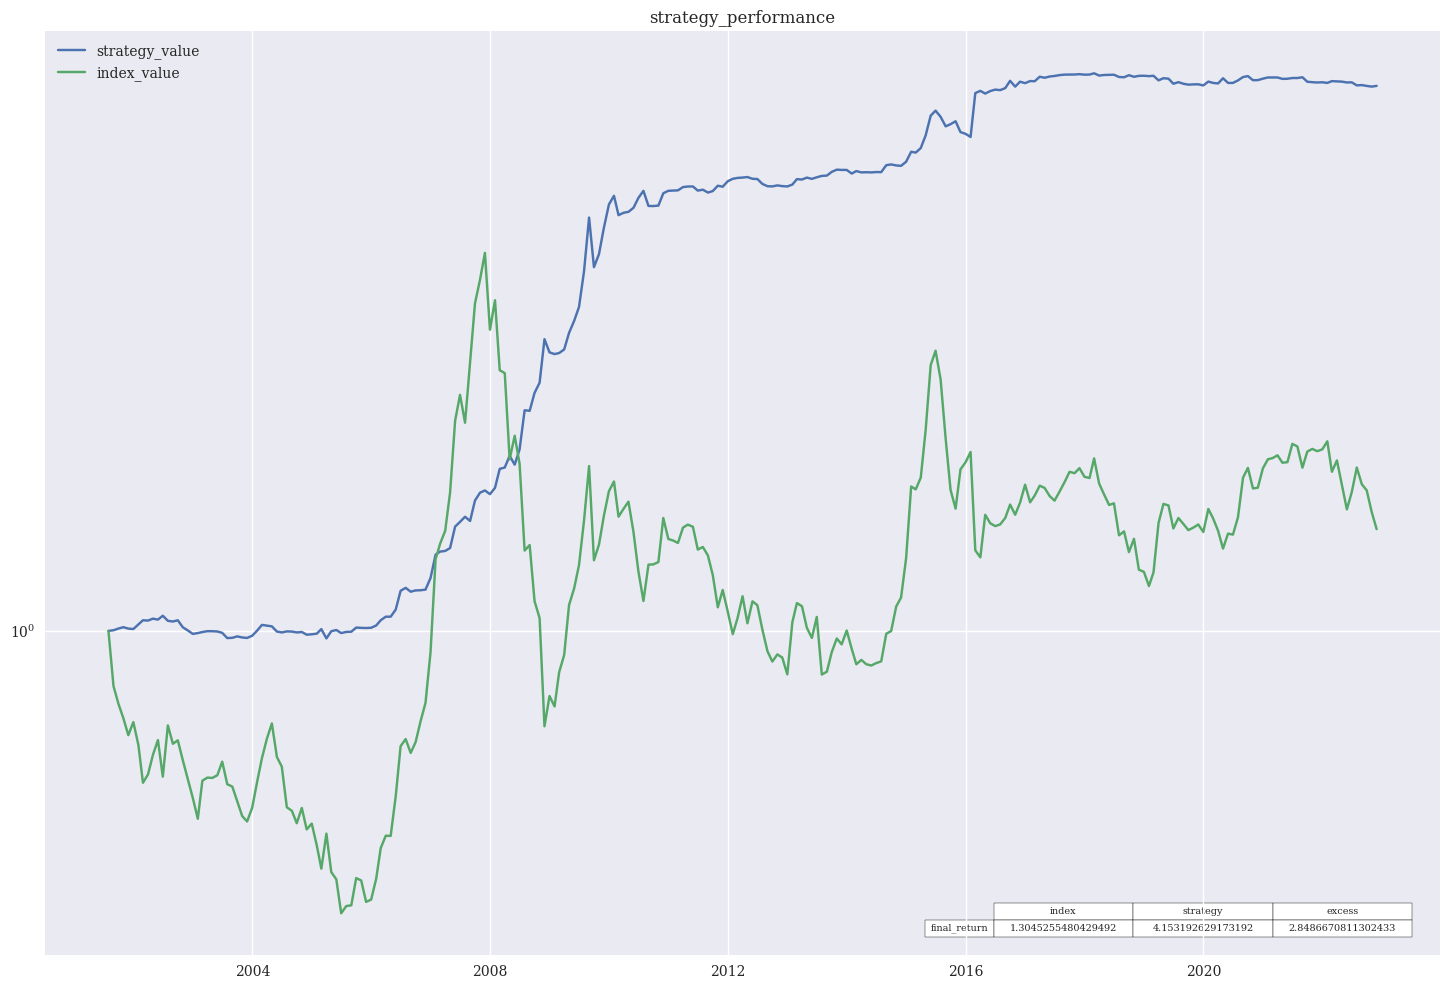

In [23]:
backtest.analysis()

###  不对冲概率调仓

In [24]:
strategy_lr2=strategy()
strategy_lr2.set_strategy(model=lr_2,factor_name=factor_names,hedge=False)
backtest=timing_backtest()
backtest.fit_data(data_backtest)
backtest.set_account(1000)
backtest.run(strategy=strategy_lr2)

当前价格: 1.0
平仓现金流入: 0.0
目前可用现金: 1000.0
当前价格: 0.8657776791917507
平仓现金流入: -438.5112288944183
目前可用现金: 1067.9828046590821
当前价格: 0.8269224613384226
平仓现金流入: -560.3049253033489
目前可用现金: 1094.3102669724374
当前价格: 0.7956915802273102
平仓现金流入: -575.9531033920398
目前可用现金: 1116.9164165718516
当前价格: 0.7615635323072875
平仓现金流入: 580.2128386546557
目前可用现金: 1090.9152614201253
当前价格: 0.7880839249622077
平仓现金流入: -581.8180811606417
目前可用现金: 1071.336072608664
当前价格: 0.7420872315014821
平仓现金流入: -610.3913078922374
目前可用现金: 1109.1698752782017
当前价格: 0.6725182583275516
平仓现金流入: -560.0372108655133
目前可用现金: 1167.1031926516157
当前价格: 0.68741256313601
平仓现金流入: -617.4767345644347
目前可用现金: 1153.7242013588502
当前价格: 0.7231217445759276
平仓现金流入: 665.3121273300467
目前可用现金: 1186.578629603072
当前价格: 0.7519058587601875
平仓现金流入: -654.84248597377
目前可用现金: 1161.5102508035586
当前价格: 0.6833693337643466
平仓现金流入: -586.4923589829656
目前可用现金: 1220.330783472013
当前价格: 0.78121386149595
平仓现金流入: -761.7535017976595
目前可用现金: 1124.9236033068241
当前价格: 0.7446223651719612
平

当前价格: 1.0911395914830184
平仓现金流入: -6525.581725790512
目前可用现金: 12054.206138442205
当前价格: 1.209558753908326
平仓现金流入: 7345.126333138721
目前可用现金: 12773.314412817343
当前价格: 1.4583572532101017
平仓现金流入: 8686.79584175004
目前可用现金: 14255.298175308322
当前价格: 1.4473952627997608
平仓现金流入: 9077.993910249552
目前可用现金: 14186.545095381285
当前价格: 1.4924533084364096
平仓现金流入: 10101.382018499004
目前可用现金: 14491.511776355443
当前价格: 1.6897438881683977
平仓现金流入: 10294.782489875028
目前可用现金: 15693.506717638375
当前价格: 2.0025244515934406
平仓现金流入: 11954.03792571575
目前可用现金: 17560.645325925794
当前价格: 2.0792092417104304
平仓现金流入: 12282.273684025182
目前可用现金: 18013.636569291033
当前价格: 1.9283896294604055
平仓现金流入: 10209.533936047445
目前可用现金: 17215.147547174165
当前价格: 1.6517942293872112
平仓现金流入: 8633.34038619078
目前可用现金: 15769.48186097523
当前价格: 1.4454216626919525
平仓现金流入: -7211.101084290577
目前可用现金: 16799.059234744785
当前价格: 1.3763494460667607
平仓现金流入: -9298.65539804968
目前可用现金: 17265.713064419044
当前价格: 1.5250309877762358
平仓现金流入: -12046.610075631961
目前可用现金: 1

-------年化收益-------
2001 7.13%
2002 -6.01%
2003 4.12%
2004 -0.68%
2005 4.69%
2006 48.28%
2007 56.47%
2008 90.34%
2009 59.16%
2010 17.43%
2011 7.79%
2012 -1.91%
2013 27.47%
2014 5.34%
2015 24.53%
2016 12.74%
2017 8.93%
2018 2.61%
2019 -9.16%
2020 10.80%
2021 2.22%
2022 -5.91%
平均年化收益率14.43%
-----夏普比率-----
夏普比率为0.6736038069437995


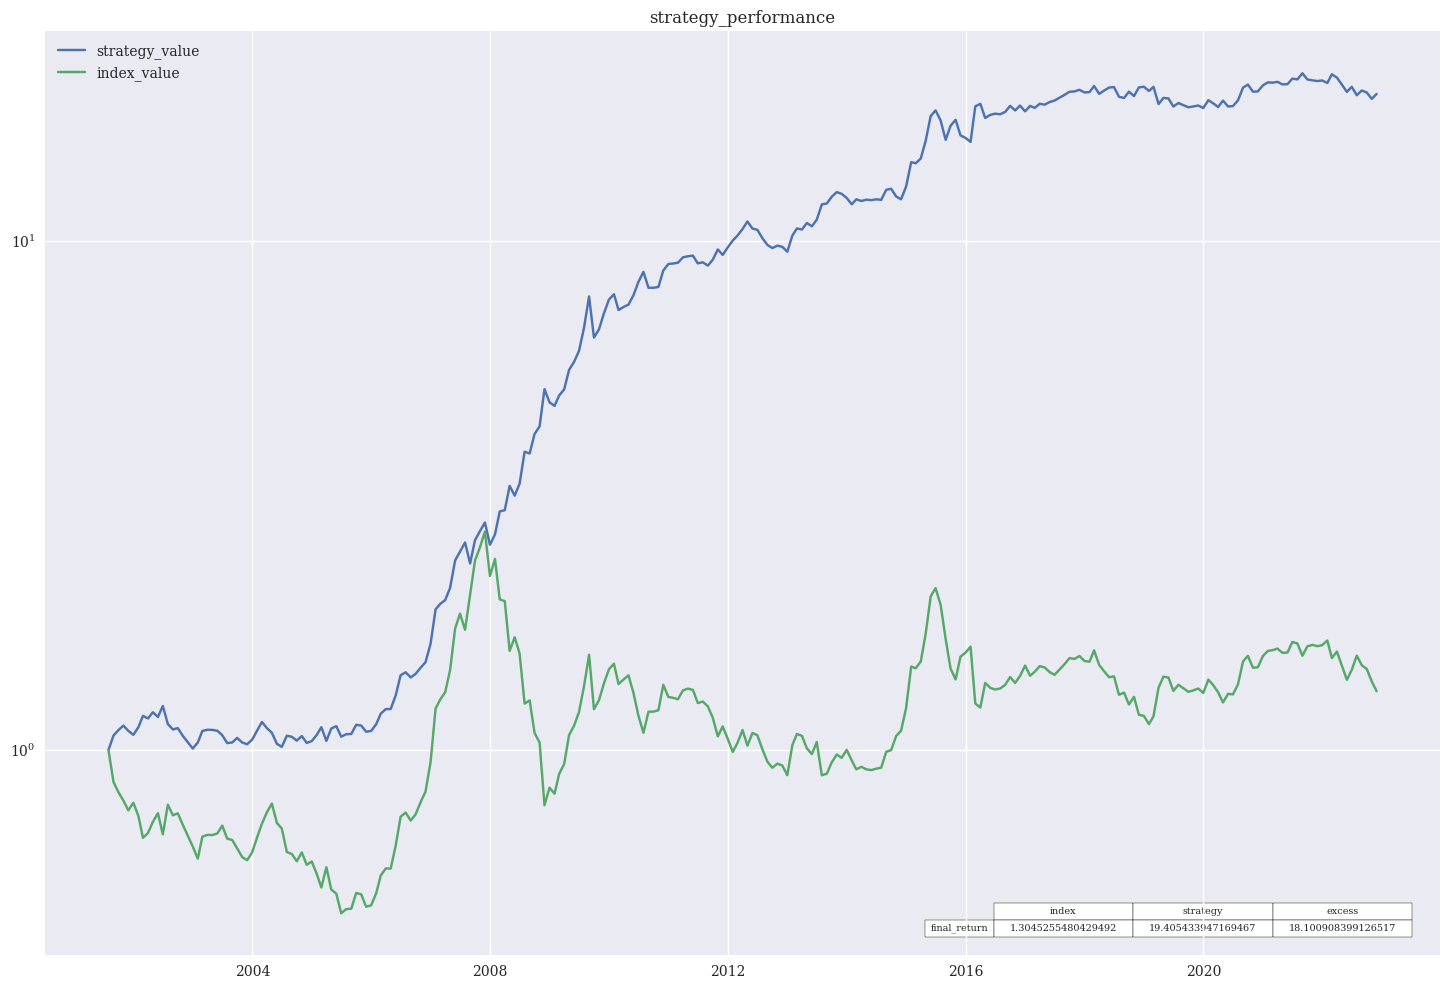

In [25]:
backtest.analysis()

### 不对冲满仓

In [26]:
strategy_lr2=strategy()
strategy_lr2.set_strategy(model=lr_2,position=1,factor_name=factor_names,hedge=False)
backtest=timing_backtest()
backtest.fit_data(data_backtest)
backtest.set_account(1000)
backtest.run(strategy=strategy_lr2)

当前价格: 1.0
平仓现金流入: 0.0
目前可用现金: 1000.0
当前价格: 0.8657776791917507
平仓现金流入: -865.7776791917507
目前可用现金: 1134.2223208082492
当前价格: 0.8269224613384226
平仓现金流入: -1083.3195816544123
目前可用现金: 1185.125059962086
当前价格: 0.7956915802273102
平仓现金流入: -1140.365724498433
目前可用现金: 1229.8843954257388
当前价格: 0.7615635323072875
平仓现金流入: 1177.1333614495002
目前可用现金: 1177.1333614495002
当前价格: 0.7880839249622077
平仓现金流入: -1218.1253964255795
目前可用现金: 1136.1413264734208
当前价格: 0.7420872315014821
平仓现金流入: -1069.8301854050808
目前可用现金: 1202.4524675417608
当前价格: 0.6725182583275516
平仓现金流入: -1089.725311075153
目前可用现金: 1315.1796240083686
当前价格: 0.68741256313601
平仓现金流入: -1344.3069911174316
目前可用现金: 1286.0522568993056
当前价格: 0.7231217445759276
平仓现金流入: 1352.85911473927
目前可用现金: 1352.85911473927
当前价格: 0.7519058587601875
平仓现金流入: -1406.7101453934629
目前可用现金: 1299.008084085077
当前价格: 0.6833693337643466
平仓现金流入: -1180.6029686208933
目前可用现金: 1417.4131995492605
当前价格: 0.78121386149595
平仓现金流入: -1620.3578127447115
目前可用现金: 1214.4685863538095
当前价格: 0.7446223651

当前价格: 1.6517942293872112
平仓现金流入: 56892.98218343843
目前可用现金: 56892.98218343843
当前价格: 1.4454216626919525
平仓现金流入: -49784.86269055244
目前可用现金: 64001.10167632441
当前价格: 1.3763494460667607
平仓现金流入: -60942.68760011298
目前可用现金: 67059.51575253584
当前价格: 1.5250309877762358
平仓现金流入: -74303.68780264341
目前可用现金: 59815.34370242826
当前价格: 1.5533639114815272
平仓现金流入: -60926.62837999269
目前可用现金: 58704.05902486383
当前价格: 1.595643402544379
平仓现金流入: -60301.86731727335
目前可用现金: 57106.25073245432
当前价格: 1.2342495566785974
平仓现金流入: -44172.378701730784
目前可用现金: 70040.12276317785
当前价格: 1.211877881761901
平仓现金流入: -68770.5943690985
目前可用现金: 71309.65115725719
当前价格: 1.3543179270346983
平仓现金流入: -79691.14742193012
目前可用现金: 62928.154892584265
当前价格: 1.324746162470077
平仓现金流入: -61554.10782149218
目前可用现金: 64302.20196367635
当前价格: 1.314959230212979
平仓现金流入: -63827.15148802347
目前可用现金: 64777.25243932923
当前价格: 1.3208157846584274
平仓现金流入: -65065.75682564093
目前可用现金: 64488.74805301754
当前价格: 1.3432379572708593
平仓现金流入: 65583.50922804266
目前可用现金: 65583.509

-------年化收益-------
2001 13.61%
2002 -11.52%
2003 8.43%
2004 -2.44%
2005 6.95%
2006 91.19%
2007 89.45%
2008 145.90%
2009 70.77%
2010 32.16%
2011 12.94%
2012 -3.02%
2013 53.92%
2014 8.10%
2015 40.91%
2016 10.65%
2017 15.92%
2018 5.01%
2019 -15.93%
2020 19.99%
2021 5.31%
2022 -11.21%
平均年化收益率21.65%
-----夏普比率-----
夏普比率为0.674422333975407


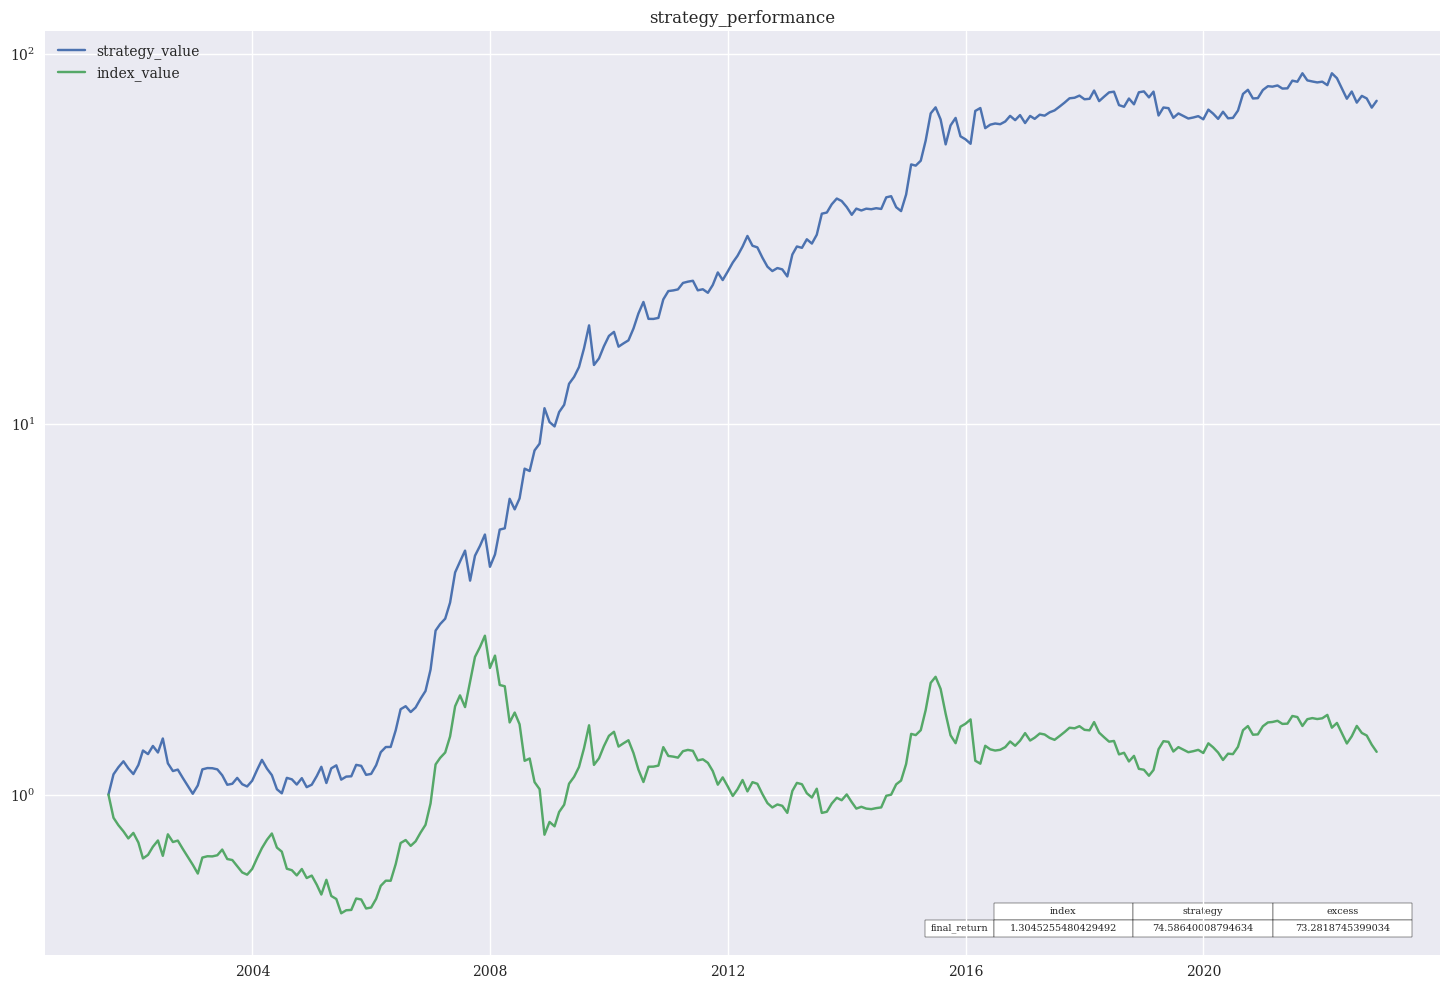

In [27]:
backtest.analysis()

#  四、特征衍生3：交互运算挖掘与PCA降维，第四次建模

首先筛选出最相关的四十个原生特征作为初始原始特征

In [28]:
xtrain=data_classification.drop(columns=["monthly_return","monthly_return_type"])
xtrain=(xtrain-xtrain.mean())/xtrain.std()
xtrain["monthly_return_type"]=data_classification['monthly_return_type']
#特征相关性筛选尝试
df_cr=xtrain.corr()['monthly_return_type'].sort_values()
print(df_cr)
ts_p=[i for i in df_cr.head(20).index]
ts_n=[i for i in df_cr.tail(20).index]
ts_select=ts_p+ts_n
ts_select.remove('monthly_return_type')
print(ts_select)

lag-13                -0.168438
lag-14                -0.148574
rollings9moment11     -0.136765
rollings9moment9      -0.134688
rollings8moment11     -0.128976
                         ...   
rollings9moment6       0.142091
rollings8moment8       0.142730
rollings9moment10      0.144432
rollings9moment8       0.146422
monthly_return_type    1.000000
Name: monthly_return_type, Length: 139, dtype: float64
['lag-13', 'lag-14', 'rollings9moment11', 'rollings9moment9', 'rollings8moment11', 'rollings9moment7', 'rollings5moment11', 'rollings8moment9', 'rollings5moment9', 'rollings7moment11', 'rollings9moment5', 'rollings8moment7', 'rollings7moment9', 'rollings4moment11', 'rollings5moment7', 'rollings4moment9', 'rollings7moment7', 'rollings4moment7', 'rollings6moment11', 'rollings6moment9', 'rollings_prod11', 'rollings5moment10', 'rollings8moment4', 'rollings7moment12', 'rollings_prod5', 'rollings7moment10', 'rollings_prod10', 'rollings5moment12', 'rollings7moment6', 'rollings7moment8', 'rolli

In [29]:
xtrain=xtrain[ts_select]
def feature_create(train):
    train = train.copy()
    xtrain = train
    colname= [i for  i in xtrain.columns]
    for i in range(len(colname)):
        for j in range(i + 1, len(colname)):
            xtrain[colname[i] + '_sub_' + colname[j]] = xtrain.iloc[:,i] - xtrain[colname[j]]
            xtrain[colname[i] + '_add_' + colname[j]] = xtrain.iloc[:,i] + xtrain[colname[j]]
            xtrain[colname[i] + '_multi_' + colname[j]] = xtrain.iloc[:,i] * xtrain[colname[j]]
            xtrain[colname[i] + '_div_' + colname[j]] = xtrain.iloc[:,i] / (xtrain.iloc[:,j] + 1)
    return xtrain

In [30]:
xtrain_new=feature_create(xtrain)
xtrain_new['monthly_return_type']=data_classification['monthly_return_type']
df_cr=xtrain_new.corr()["monthly_return_type"].sort_values()
abs(df_cr).sort_values()

rollings4moment11_sub_rollings5moment7    0.000021
rollings9moment5_sub_rollings8moment7     0.000149
rollings_prod10_sub_rollings5moment12     0.000159
rollings7moment7_sub_rollings4moment7     0.000174
rollings9moment12_sub_rollings8moment6    0.000183
                                            ...   
lag-13_add_lag-14                         0.211327
lag-13_sub_rollings9moment6               0.212562
lag-13_sub_rollings8moment6               0.213864
lag-13_sub_rollings_prod10                0.214355
monthly_return_type                       1.000000
Name: monthly_return_type, Length: 3004, dtype: float64

##  衍生特征可视化分析

<AxesSubplot:title={'center':'nagtive_feature'}, xlabel='feature_name'>

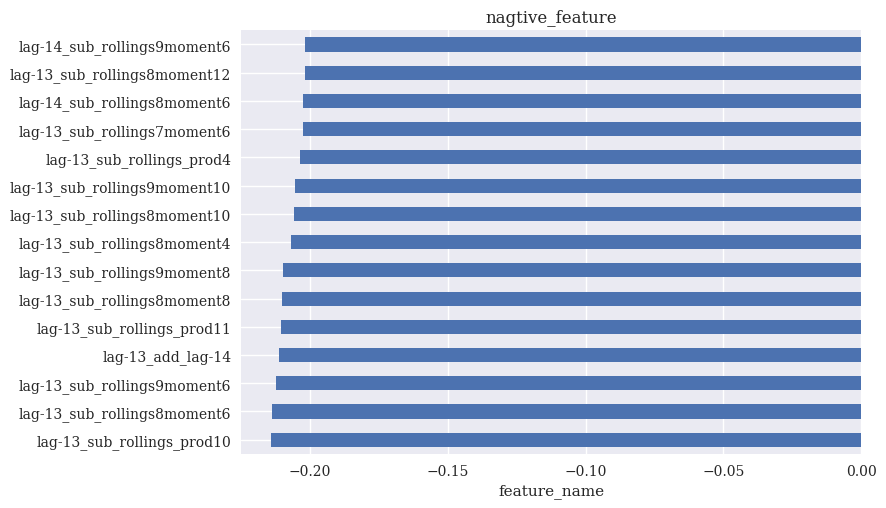

In [31]:
df_cr.head(15).plot.barh(title="nagtive_feature",xlabel='feature_name')

<AxesSubplot:title={'center':'positive_feature'}, xlabel='feature_name'>

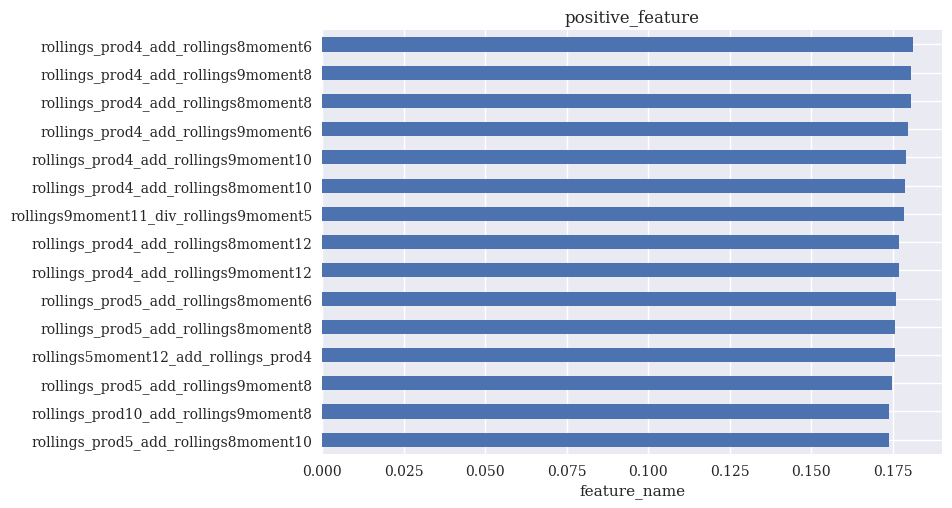

In [32]:
df_cr[:-1].tail(15).plot.barh(title="positive_feature",xlabel='feature_name')

## 特征效果建模尝试

In [33]:
#全特征
y=xtrain_new['monthly_return_type']
x=xtrain_new.drop(columns=['monthly_return_type'])
factor_names=[i for i in x.columns]
lr_3=LogisticRegression().fit(x,y)
print("auc:",roc_auc_score(y,lr_3.predict_proba(x)[:,1]))
print("accuracy:",lr_3.score(x,y))

auc: 0.8823529411764707
accuracy: 0.7665369649805448


In [34]:
#精简版20特征
ts_select=[i for i in abs(df_cr).sort_values().tail(20).index]
ts_select.remove('monthly_return_type')
xtrain_simple=xtrain_new[ts_select]
y=xtrain_new['monthly_return_type']
lr_4=LogisticRegression().fit(xtrain_simple,y)
print("auc:",roc_auc_score(y,lr_4.predict_proba(xtrain_simple)[:,1]))
print("accuracy:",lr_4.score(xtrain_simple,y))

auc: 0.6656538648517257
accuracy: 0.6147859922178989


In [35]:
#尝试使用PCA来降维
from sklearn.decomposition import PCA
pca = PCA(svd_solver='auto')
pca.fit(x)
x_reduced = pca.transform(x)
print(x_reduced.shape)
lr_5=LogisticRegression().fit(x_reduced,y)
print("auc:",roc_auc_score(y,lr_5.predict_proba(x_reduced)[:,1]))
print("accuracy:",lr_5.score(x_reduced,y))

(257, 257)
auc: 0.8706246961594554
accuracy: 0.7665369649805448


In [36]:
#尝试继续用mle来降维
pca1=PCA(n_components="mle")
pca1.fit(x_reduced)
x_reduced_1=pca1.transform(x_reduced)
print(x_reduced_1.shape)
lr_6=LogisticRegression().fit(x_reduced_1,y)
print("auc:",roc_auc_score(y,lr_6.predict_proba(x_reduced_1)[:,1]))
print("accuracy:",lr_6.score(x_reduced_1,y))

(257, 206)
auc: 0.8768230432668935
accuracy: 0.77431906614786


## 尝试验证样本外

In [37]:
#移动窗口
windows=5
train_size=0.7
count=x_reduced_1.shape[0]//windows
for i in range(windows):
    print('windows:',i)
    windows_x,windows_y=x_reduced_1[i*count:(i+1)*count],y[i*count:(i+1)*count]
    threshold=int(count*train_size)
    x_train,y_train=windows_x[:threshold],windows_y[:threshold]
    x_test,y_test=windows_x[threshold:],windows_y[threshold:]
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import roc_auc_score
    lr=LogisticRegression().fit(x_train,y_train)
    print(x_train.shape,x_test.shape)
    print(y_train.shape,y_test.shape)
    #查看模型拟合效果
    print("train_auc:",roc_auc_score(y_train,lr.predict_proba(x_train)[:,1]))
    print("train_accuracy:",lr.score(x_train,y_train))
    print("test_auc:",roc_auc_score(y_test,lr.predict_proba(x_test)[:,1]))
    print("test_accuracy:",lr.score(x_test,y_test))
    print('------------------------------------------------')

windows: 0
(35, 206) (16, 206)
(35,) (16,)
train_auc: 0.9833333333333333
train_accuracy: 0.9428571428571428
test_auc: 0.6
test_accuracy: 0.5625
------------------------------------------------
windows: 1
(35, 206) (16, 206)
(35,) (16,)
train_auc: 1.0
train_accuracy: 1.0
test_auc: 0.41666666666666663
test_accuracy: 0.5625
------------------------------------------------
windows: 2
(35, 206) (16, 206)
(35,) (16,)
train_auc: 1.0
train_accuracy: 0.9714285714285714
test_auc: 0.46875
test_accuracy: 0.5
------------------------------------------------
windows: 3
(35, 206) (16, 206)
(35,) (16,)
train_auc: 1.0
train_accuracy: 1.0
test_auc: 0.5
test_accuracy: 0.5625
------------------------------------------------
windows: 4
(35, 206) (16, 206)
(35,) (16,)
train_auc: 0.9166666666666666
train_accuracy: 0.8285714285714286
test_auc: 0.6825396825396826
test_accuracy: 0.625
------------------------------------------------


In [38]:
stop

NameError: name 'stop' is not defined

根据特征效果尝试最终选用PCA降维到206维度的特征进行建模

##  第四次回测

In [39]:
xtrain_reduced=pd.DataFrame(x_reduced_1,index=x.index)
factor_names=[i for i in xtrain_reduced.columns]
xtrain_reduced['monthly_return_type']=y
xtrain_reduced['monthly_return']=data_classification['monthly_return']
data_backtest=xtrain_reduced.copy()
data_backtest['close']=data_backtest['monthly_return'].shift(1).cumprod()
data_backtest.iloc[0,-1]=1
data_backtest

,0,1,2,3,4,5,6,7,8,9,...,199,200,201,202,203,204,205,monthly_return_type,monthly_return,close
trade_date,,,,,,,,,,,,,,,,,,,,,
2001-07-31,-16.714342,-19.347102,-5.244662,-2.438979,1.462889,-1.238629,-1.166121,-0.190578,0.032862,-4.332559,...,-0.000108,-0.000143,-0.000075,-0.000099,0.000022,0.000109,-0.000106,0,0.865778,1.000000
2001-08-31,-16.484049,-19.253141,-5.329244,-1.180434,0.181090,-0.334594,-1.260685,-1.106149,1.424617,5.267291,...,-0.000034,0.000033,-0.000014,0.000058,0.000010,-0.000034,-0.000033,0,0.955121,0.865778
2001-09-30,-16.313671,-19.675695,-6.478703,0.200167,0.399897,1.113311,-1.686333,-1.382604,4.345253,11.929306,...,0.000007,-0.000039,0.000046,-0.000019,0.000002,0.000009,-0.000003,0,0.962232,0.826922
2001-10-31,-16.041661,-19.451926,-6.875377,-2.533866,3.689000,-6.335491,-2.774779,-0.072230,6.378477,8.547146,...,-0.000014,0.000016,-0.000001,0.000041,0.000025,0.000008,-0.000034,0,0.957109,0.795692
2001-11-30,-14.846585,-19.248135,-6.205969,-0.037473,-0.333190,0.602539,-3.333608,-3.032559,3.268146,14.261160,...,0.000014,-0.000039,-0.000007,0.000073,0.000007,0.000037,-0.000017,1,1.034824,0.761564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-31,-16.425000,-19.446030,-5.916585,-1.400631,1.096667,-0.137622,-1.773932,-1.081433,2.273495,2.804169,...,-0.000192,-0.000289,-0.000358,0.000071,-0.000200,0.000343,-0.000099,0,0.957224,1.532265
2022-08-31,-16.377289,-19.441534,-6.241266,-0.605722,2.236815,-1.566698,-2.632082,-0.705545,3.933554,5.476022,...,-0.000191,-0.000409,0.000503,-0.000127,0.000499,0.000210,-0.000258,0,0.984292,1.466721
2022-09-30,-15.940888,-19.448862,-5.720886,-1.307649,1.988046,-2.767064,-2.454313,0.108742,1.658257,3.733958,...,0.000197,-0.000291,-0.000034,-0.000006,-0.000580,-0.000017,0.000102,0,0.944491,1.443682


###  对冲

In [ ]:
strategy_lr6=strategy()
strategy_lr6.set_strategy(model=lr_6,factor_name=factor_names,hedge=True)
backtest=timing_backtest()
backtest.fit_data(data_backtest)
backtest.set_account(1000)
backtest.run(strategy=strategy_lr6)

In [ ]:
backtest.analysis()

### 不对冲自动调仓

In [ ]:
strategy_lr6=strategy()
strategy_lr6.set_strategy(model=lr_6,factor_name=factor_names,hedge=False)
backtest=timing_backtest()
backtest.fit_data(data_backtest)
backtest.set_account(1000)
backtest.run(strategy=strategy_lr6)

In [ ]:
backtest.analysis()

### 不对冲满仓

In [ ]:
strategy_lr6=strategy()
strategy_lr6.set_strategy(model=lr_6,position=1,factor_name=factor_names,hedge=False)
backtest=timing_backtest()
backtest.fit_data(data_backtest)
backtest.set_account(1000)
backtest.run(strategy=strategy_lr6)

In [ ]:
backtest.analysis()

#  五、机器学习LGBM尝试，建立第五个模型

##  首先解决LGBM时间序列的cv问题，具体实现见源码

In [ ]:
xtrain_reduced

In [ ]:
from lgbmcv import ts_cv

In [ ]:
#利用ts_cv先搜索超参数
param={
    "n_jobs":[-1],
    "n_estimators":[100,200,300],
    "learning_rate":[0.05,0.03,0.01,0.006],
    "max_depth":[3,4],
    'metric': ['auc'],
    'min_child_samples': [10,15,20],
    'min_child_weight': [0],
    'objective': ['binary'],
    'colsample_bytree': [1,0.7,0.5],
}
instance=ts_cv()
instance.fit(factor_name=factor_names,target="monthly_return_type")

In [ ]:
instance.cv_search(ts=xtrain_reduced,param=param,n_split=3,test_size=0.5)

##  使用最优参数进行cv训练模型存储

In [ ]:
instance.cv_train()

##  回测

### 对冲

In [ ]:
data_backtest=xtrain_reduced.copy()
data_backtest['close']=data_backtest['monthly_return'].shift(1).cumprod()
data_backtest.iloc[0,-1]=1
strategy_lgbm=strategy()
strategy_lgbm.set_strategy(model=instance,factor_name=factor_names,hedge=True)
backtest=timing_backtest()
backtest.fit_data(data_backtest)
backtest.set_account(1000)
backtest.run(strategy=strategy_lgbm)

In [ ]:
backtest.analysis()

## 不对冲概率仓位

In [ ]:
strategy_lgbm=strategy()
strategy_lgbm.set_strategy(model=instance,factor_name=factor_names,hedge=False)
backtest=timing_backtest()
backtest.fit_data(data_backtest)
backtest.set_account(1000)
backtest.run(strategy=strategy_lgbm)

In [ ]:
backtest.analysis()

## 不对冲满仓

In [ ]:
strategy_lgbm=strategy()
strategy_lgbm.set_strategy(model=instance,factor_name=factor_names,position=1,hedge=False)
backtest=timing_backtest()
backtest.fit_data(data_backtest)
backtest.set_account(1000)
backtest.run(strategy=strategy_lgbm)

In [ ]:
backtest.analysis()

#  六、神经网络LSTM尝试，第六次建模

In [40]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation

##  依然需要进行cv处理，以及一些必要参数设置详细见源代码

## 数据预处理

In [41]:
seq_length =12
num_samples = xtrain_reduced.shape[0]-seq_length
x_data = np.zeros((num_samples, seq_length, len(factor_names)))
y_data = np.zeros((num_samples, 2))
for i in range(num_samples):
    x_data[i] = xtrain_reduced[factor_names][i:i+seq_length]
    if (xtrain_reduced[["monthly_return"]].iloc[i+seq_length,:]>1).values:
        y_data[i] = [1, 0]
    else:
        y_data[i] = [0, 1]

In [42]:
x_data.shape

(245, 12, 206)

In [43]:
import warnings
warnings.filterwarnings('ignore')
from lstmcv import lstm_cv

In [44]:
#叠加验证
instance_stack=lstm_cv()
instance_stack.fit_data(x_data,y_data)
instance_stack.data_split(n_split=5,method="stack")
instance_stack.cv_train()

第0次训练
Epoch 1/30
2/2 [==============================] - 1s 319ms/step - loss: 0.6982 - val_loss: 1.0480
Epoch 2/30
2/2 [==============================] - 0s 21ms/step - loss: 0.4890 - val_loss: 1.2334
Epoch 3/30
2/2 [==============================] - 0s 22ms/step - loss: 0.4808 - val_loss: 1.3810
Epoch 4/30
2/2 [==============================] - 0s 22ms/step - loss: 0.4938 - val_loss: 1.3526
Epoch 5/30
2/2 [==============================] - 0s 22ms/step - loss: 0.4395 - val_loss: 1.1953
Epoch 6/30
2/2 [==============================] - 0s 21ms/step - loss: 0.3637 - val_loss: 0.9975
Epoch 7/30
2/2 [==============================] - 0s 22ms/step - loss: 0.3534 - val_loss: 0.9271
Epoch 8/30
2/2 [==============================] - 0s 22ms/step - loss: 0.3855 - val_loss: 0.9501
Epoch 9/30
2/2 [==============================] - 0s 22ms/step - loss: 0.3681 - val_loss: 1.0847
Epoch 10/30
2/2 [==============================] - 0s 27ms/step - loss: 0.3092 - val_loss: 1.2948
Epoch 11/30
2/2 [=====

4/4 [==============================] - 0s 10ms/step - loss: 0.0204 - val_loss: 1.1508
Epoch 23/30
4/4 [==============================] - 0s 10ms/step - loss: 0.0178 - val_loss: 1.1685
Epoch 24/30
4/4 [==============================] - 0s 10ms/step - loss: 0.0155 - val_loss: 1.1884
Epoch 25/30
4/4 [==============================] - 0s 10ms/step - loss: 0.0139 - val_loss: 1.2097
Epoch 26/30
4/4 [==============================] - 0s 10ms/step - loss: 0.0130 - val_loss: 1.2228
Epoch 27/30
4/4 [==============================] - 0s 10ms/step - loss: 0.0122 - val_loss: 1.2296
Epoch 28/30
4/4 [==============================] - 0s 10ms/step - loss: 0.0113 - val_loss: 1.2334
Epoch 29/30
4/4 [==============================] - 0s 10ms/step - loss: 0.0106 - val_loss: 1.2388
Epoch 30/30
2/2 [==============================] - 0s 2ms/step
第3次训练
Epoch 1/30
5/5 [==============================] - 1s 77ms/step - loss: 0.7491 - val_loss: 0.8398
Epoch 2/30
5/5 [==============================] - 0s 8ms/step 

In [45]:
instance_stack.cv_val()

train_auc_list [1. 1. 1. 1. 1.]
test_auc_list [0.36       0.44907407 0.59126984 0.52893519 0.4254386 ]
train_auc: 1.0 test_auc: 0.4709435394040657


In [46]:
#固定验证
instance=lstm_cv()
instance.fit_data(x_data,y_data)
instance.data_split(n_split=10,method="fixed")
instance.cv_train()

(16, 12, 206) (8, 12, 206)
(16, 12, 206) (8, 12, 206)
(16, 12, 206) (8, 12, 206)
(16, 12, 206) (8, 12, 206)
(16, 12, 206) (8, 12, 206)
(16, 12, 206) (8, 12, 206)
(16, 12, 206) (8, 12, 206)
(16, 12, 206) (8, 12, 206)
(16, 12, 206) (8, 12, 206)
(16, 12, 206) (8, 12, 206)
第0次训练
Epoch 1/30
1/1 [==============================] - 1s 1s/step - loss: 1.0317 - val_loss: 1.4701
Epoch 2/30
1/1 [==============================] - 0s 23ms/step - loss: 0.6747 - val_loss: 1.4483
Epoch 3/30
1/1 [==============================] - 0s 22ms/step - loss: 0.4767 - val_loss: 1.2540
Epoch 4/30
1/1 [==============================] - 0s 23ms/step - loss: 0.3649 - val_loss: 1.2075
Epoch 5/30
1/1 [==============================] - 0s 23ms/step - loss: 0.3048 - val_loss: 1.2456
Epoch 6/30
1/1 [==============================] - 0s 23ms/step - loss: 0.2487 - val_loss: 1.3209
Epoch 7/30
1/1 [==============================] - 0s 24ms/step - loss: 0.2153 - val_loss: 1.4284
Epoch 8/30
1/1 [==============================]

Epoch 20/30
1/1 [==============================] - 0s 23ms/step - loss: 0.0195 - val_loss: 3.1012
Epoch 21/30
1/1 [==============================] - 0s 22ms/step - loss: 0.0173 - val_loss: 3.1404
Epoch 22/30
1/1 [==============================] - 0s 22ms/step - loss: 0.0153 - val_loss: 3.1717
Epoch 23/30
1/1 [==============================] - 0s 22ms/step - loss: 0.0136 - val_loss: 3.1924
Epoch 24/30
1/1 [==============================] - 0s 22ms/step - loss: 0.0121 - val_loss: 3.2019
Epoch 25/30
1/1 [==============================] - 0s 23ms/step - loss: 0.0108 - val_loss: 3.2045
Epoch 26/30
1/1 [==============================] - 0s 29ms/step - loss: 0.0096 - val_loss: 3.2043
Epoch 27/30
1/1 [==============================] - 0s 22ms/step - loss: 0.0086 - val_loss: 3.2020
Epoch 28/30
1/1 [==============================] - 0s 24ms/step - loss: 0.0078 - val_loss: 3.1966
Epoch 29/30
1/1 [==============================] - 0s 22ms/step - loss: 0.0070 - val_loss: 3.1910
Epoch 30/30
1/1 [===

1/1 [==============================] - 0s 18ms/step
第5次训练
Epoch 1/30
1/1 [==============================] - 1s 1s/step - loss: 0.7979 - val_loss: 0.8587
Epoch 2/30
1/1 [==============================] - 0s 22ms/step - loss: 0.5391 - val_loss: 0.8831
Epoch 3/30
1/1 [==============================] - 0s 22ms/step - loss: 0.4611 - val_loss: 0.9581
Epoch 4/30
1/1 [==============================] - 0s 23ms/step - loss: 0.3482 - val_loss: 1.0442
Epoch 5/30
1/1 [==============================] - 0s 22ms/step - loss: 0.2764 - val_loss: 1.1713
Epoch 6/30
1/1 [==============================] - 0s 23ms/step - loss: 0.2324 - val_loss: 1.3031
Epoch 7/30
1/1 [==============================] - 0s 23ms/step - loss: 0.1882 - val_loss: 1.4296
Epoch 8/30
1/1 [==============================] - 0s 24ms/step - loss: 0.1495 - val_loss: 1.5641
Epoch 9/30
1/1 [==============================] - 0s 29ms/step - loss: 0.1218 - val_loss: 1.7029
Epoch 10/30
1/1 [==============================] - 0s 24ms/step - loss:

1/1 [==============================] - 0s 23ms/step - loss: 0.0246 - val_loss: 2.3226
Epoch 22/30
1/1 [==============================] - 0s 23ms/step - loss: 0.0212 - val_loss: 2.4246
Epoch 23/30
1/1 [==============================] - 0s 23ms/step - loss: 0.0165 - val_loss: 2.4313
Epoch 24/30
1/1 [==============================] - 0s 23ms/step - loss: 0.0129 - val_loss: 2.4274
Epoch 25/30
1/1 [==============================] - 0s 23ms/step - loss: 0.0111 - val_loss: 2.4458
Epoch 26/30
1/1 [==============================] - 0s 23ms/step - loss: 0.0097 - val_loss: 2.4982
Epoch 27/30
1/1 [==============================] - 0s 23ms/step - loss: 0.0080 - val_loss: 2.5745
Epoch 28/30
1/1 [==============================] - 0s 23ms/step - loss: 0.0065 - val_loss: 2.6568
Epoch 29/30
1/1 [==============================] - 0s 24ms/step - loss: 0.0054 - val_loss: 2.7292
Epoch 30/30
1/1 [==============================] - 0s 14ms/step
第8次训练
Epoch 1/30
1/1 [==============================] - 1s 1s/step

In [47]:
instance.cv_val()

train_auc_list [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
test_auc_list [0.2        0.57142857 0.66666667 0.5625     0.53333333 0.25
 0.8125     0.41666667 0.26666667 0.46666667]
train_auc: 1.0 test_auc: 0.4746428571428571


神经网络在这个问题上过拟合让人难以接受，因此最终结果也可信度不高